This EDA aims at:
1. understanding the data - identifying data types, identifying missing data, checking for outliers.
2. Cleaning up data, filling in missing data, changing feature data types and handling outliers
3. Answering Questions about Operations

In [592]:
#importing libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import missingno as msg
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [593]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 150)

In [594]:
# data path
data = r"carrier_kpi_geographic_15000.csv"

In [595]:
# loading data to dataframe
df = pd.read_csv(data)

In [596]:
# looking at first 5 rows

df.head()

carrier_name carrier_number shipment_number shipment_date delivery_date delivery_reliability feedback_reliability non_conformance_count  \
0    Hapag-Lloyd       CR-904-C       SHP904437    2023-06-04    2023-06-10                    1                    1                     0   
1          COSCO       CR-533-B       SHP499266    2024-04-07    2024-04-18                    1                    0                     0   
2    Hapag-Lloyd       CR-970-A       SHP227384    2023-09-13    2023-09-16                    1                    0                     0   
3  XPO Logistics         977970       SHP516508    2025-02-15    2025-02-26                   No                    0                     0   
4         Maersk       CR-601-A       SHP976649    2023-06-15    2023-06-19                    1                    1                     0   

  transport_mode shipment_weight_kg  ...         region origin_country origin_postal_code destination_country  destination_postal_code distance_km  \
0           Road            3295.59  ...  Latin America             CO             307576                  BR                    76521     5995.28   
1            Sea           88103.65  ...         Africa             ZA             494082                  NG                   577543     7614.42   
2            Air            1499.37  ...           Asia             IN             827682                  JP                   742986     1439.82   
3           Road            3105.12  ...         Europe             SE               5023                  ZA                   850479    11789.43   
4           Road           24345.03  ...  North America             MX              98054                  EG                   771949     5154.71   

   lead_time_days  co2_emission_kg                remarks  data_entry_source  
0               6          3556.43              No issues             Manual  
1              11         10062.87           Customs hold              Email  
2               3          1295.29     Left at front desk                API  
3              11          6589.36  Documentation missing             Manual  
4               4         22588.48  Documentation missing                EDI  

[5 rows x 22 columns]

In [597]:
# checking df info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carrier_name             15000 non-null  object 
 1   carrier_number           14923 non-null  object 
 2   shipment_number          14923 non-null  object 
 3   shipment_date            14923 non-null  object 
 4   delivery_date            14923 non-null  object 
 5   delivery_reliability     15000 non-null  object 
 6   feedback_reliability     14681 non-null  object 
 7   non_conformance_count    15000 non-null  object 
 8   transport_mode           15000 non-null  object 
 9   shipment_weight_kg       14859 non-null  object 
 10  cost_usd                 14768 non-null  object 
 11  status                   15000 non-null  object 
 12  region                   15000 non-null  object 
 13  origin_country           15000 non-null  object 
 14  origin_postal_code    

1. The delivery date will be used because the KPIs are only relevant after the goods are delivered. This is an object and must be converted into date format.
2. Delivery reliability is a boolean. Must be converted to INT.
3. Feedback reliability is a boolean. Must be converted to INT.
4. Non conformance count is a boolean. Must be converted to INT.
5. Shimpent weight kg is a float.
6. cost usd is a float

In [598]:
clean_df = df.copy()

1. Converting delivery date to date format

In [599]:
clean_df['delivery_date'].value_counts()

delivery_date
2025-01-17    28
2023-12-01    25
2025-07-10    25
2025-05-07    25
2023-02-13    25
              ..
09/28/2025     1
03/20/2025     1
03/26/2025     1
02/21/2025     1
08/22/2025     1
Name: count, Length: 1416, dtype: int64

#### It looks like the delivery date has multiple format types. 
#### I will convert them into a consistent format to enable converting them to date format

In [600]:
from datetime import datetime

def date_reformatter(date_value):

    """This function standardises inconsistent date formats"""
    if not date_value or not isinstance(date_value, str):
        return None  # handle nulls or non-strings

    # unify separators
    date_value = date_value.replace("/", "-")

    # try multiple formats
    for fmt in ("%Y-%m-%d", "%d-%m-%Y", "%m-%d-%Y"):
        try:
            d = datetime.strptime(date_value, fmt)
            return d.strftime("%Y-%m-%d")  # normalized output
        except ValueError:
            continue  # try next format

    # fallback if none worked
    return date_value

In [601]:
#standardizing the date formats
clean_df["delivery_date"] = clean_df["delivery_date"].apply(date_reformatter)

In [602]:
# checking the data type
clean_df['delivery_date'].dtype

dtype('O')

In [603]:
# converting to date type
clean_df["delivery_date"] = pd.to_datetime(clean_df["delivery_date"])

In [604]:
# Spot Check
clean_df['delivery_date'].dtype

dtype('<M8[ns]')

2. Converting Delivery Reliability to boolean

In [605]:
df["delivery_reliability"].unique()

array(['1', 'No', '0', 'Yes'], dtype=object)

There are different types of unique values for "delivery_reliability". I simply need them to be a boolean. 
##### I will convert yes, true to 1 and no, false, nan to 0

In [606]:
df["delivery_reliability"].value_counts()

delivery_reliability
0      7149
1      7127
No      367
Yes     357
Name: count, dtype: int64

In [607]:
def boolean_standardiser(value):
    """Standardises various boolean-like inputs into either 1 or 0."""
    if value is None:
        return 0  # handle missing values

    # Convert to string and lowercase once
    val_str = str(value).strip().lower()

    if val_str in ("yes", "true", "1", "y", "t"):
        return 1
    else:
        return 0


In [608]:
#applying boolean standardiser to the delivery reliability column
df["delivery_reliability"] = df["delivery_reliability"].apply(boolean_standardiser)

In [609]:
# spot checks
df["delivery_reliability"].dtype

dtype('int64')

In [610]:
# spot checks
df["delivery_reliability"].value_counts()

delivery_reliability
0    7516
1    7484
Name: count, dtype: int64

3. Feedback reliability is a boolean. Must be converted to INT.

In [611]:
# Applying boolean function to the reliability column
df["feedback_reliability"] = df["feedback_reliability"].apply(boolean_standardiser)

In [612]:
# spot checks
df["feedback_reliability"].dtype

dtype('int64')

In [613]:
# spot checks
df["feedback_reliability"].value_counts()

feedback_reliability
0    7810
1    7190
Name: count, dtype: int64

4. Non conformance count is a boolean. Must be converted to INT.

In [614]:
# spot checks
df['non_conformance_count'].value_counts()

non_conformance_count
0      12506
1        827
2        776
3        759
Yes      132
Name: count, dtype: int64

In [615]:
# Applying boolean function to the reliability column
df["non_conformance_count"] = df['non_conformance_count'].apply(boolean_standardiser)

In [616]:
# Spot Checks
df['non_conformance_count'].dtype

dtype('int64')

In [617]:
# Spot Checks
df['non_conformance_count'].value_counts()

non_conformance_count
0    14041
1      959
Name: count, dtype: int64

In [618]:
# Spot Checks
df["shipment_weight_kg"]

0         3295.59
1        88103.65
2         1499.37
3         3105.12
4        24345.03
           ...   
14995    91539.19
14996    76246.29
14997     9058.37
14998    10541.51
14999      605.66
Name: shipment_weight_kg, Length: 15000, dtype: object

5. Shipment weight kg is a float.

In [619]:
def weight_formatter(value):

    """This function strips the kg and g from weights where applicable. It converts grams into kilos by dividing the value by 1000
    """

    if value is None:
        return 0
    
    val_str = str(value).strip().lower()

    if "g" in val_str and "kg" not in val_str:
        formatted_val = float(val_str.replace("g","").strip())/1000
    else:
        formatted_val = float(val_str.replace("kg","").strip())  # handles kg and numbers

    return formatted_val
    


In [620]:
# applying the shipment weight function to a new shipment_weight_kg column
clean_df["shipment_weight_kg_f"] = clean_df["shipment_weight_kg"].apply(weight_formatter)

In [621]:
# spot checks
clean_df["shipment_weight_kg"].isna().sum()

np.int64(141)

In [622]:
#spot checks
clean_df.head()

carrier_name carrier_number shipment_number shipment_date delivery_date delivery_reliability feedback_reliability non_conformance_count  \
0    Hapag-Lloyd       CR-904-C       SHP904437    2023-06-04    2023-06-10                    1                    1                     0   
1          COSCO       CR-533-B       SHP499266    2024-04-07    2024-04-18                    1                    0                     0   
2    Hapag-Lloyd       CR-970-A       SHP227384    2023-09-13    2023-09-16                    1                    0                     0   
3  XPO Logistics         977970       SHP516508    2025-02-15    2025-02-26                   No                    0                     0   
4         Maersk       CR-601-A       SHP976649    2023-06-15    2023-06-19                    1                    1                     0   

  transport_mode shipment_weight_kg  ... origin_country origin_postal_code destination_country destination_postal_code  distance_km lead_time_days  \
0           Road            3295.59  ...             CO             307576                  BR                   76521      5995.28              6   
1            Sea           88103.65  ...             ZA             494082                  NG                  577543      7614.42             11   
2            Air            1499.37  ...             IN             827682                  JP                  742986      1439.82              3   
3           Road            3105.12  ...             SE               5023                  ZA                  850479     11789.43             11   
4           Road           24345.03  ...             MX              98054                  EG                  771949      5154.71              4   

   co2_emission_kg                remarks  data_entry_source  shipment_weight_kg_f  
0          3556.43              No issues             Manual               3295.59  
1         10062.87           Customs hold              Email              88103.65  
2          1295.29     Left at front desk                API               1499.37  
3          6589.36  Documentation missing             Manual               3105.12  
4         22588.48  Documentation missing                EDI              24345.03  

[5 rows x 23 columns]

In [623]:
clean_df.groupby("transport_mode").agg({"shipment_weight_kg_f": "mean"})

shipment_weight_kg_f
transport_mode                      
Air                          2486.32
Rail                        23762.38
Road                         6661.60
Sea                         59000.93
air                          2606.48
air freight                  3110.02
rail                        23681.75
road                         6245.09
sea                         58060.45

The above example also shows that transport mode column must be standardised


6. cost usd is a float

In [624]:
def cost_standardiser(cost):
    if cost is None:
        return None
    
    cost_str = str(cost).strip().upper()

   
    formatted_cost = cost_str.replace("$","").replace("USD","").replace("DOLLARS","").strip()
        
    formatted_cost = float(formatted_cost)

    return formatted_cost

        

In [625]:
#applying the cost standardiser to the the cost_usd function
clean_df['cost_usd'] = clean_df['cost_usd'].apply(cost_standardiser)

In [626]:
# spot checks
clean_df['cost_usd'].mean()

np.float64(14953.201487676055)

Dropping Null Rows where the Carrier ID is null 

In [627]:
clean_df = clean_df.dropna(subset='carrier_number')

In [628]:
#spot checks

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14923 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   carrier_name             14923 non-null  object        
 1   carrier_number           14923 non-null  object        
 2   shipment_number          14923 non-null  object        
 3   shipment_date            14923 non-null  object        
 4   delivery_date            14923 non-null  datetime64[ns]
 5   delivery_reliability     14923 non-null  object        
 6   feedback_reliability     14605 non-null  object        
 7   non_conformance_count    14923 non-null  object        
 8   transport_mode           14923 non-null  object        
 9   shipment_weight_kg       14782 non-null  object        
 10  cost_usd                 14768 non-null  float64       
 11  status                   14923 non-null  object        
 12  region                   14923 non-nu

Dropping Null Rows where the Date is null 

In [629]:
clean_df = clean_df.dropna(subset="delivery_date")

In [630]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14923 entries, 0 to 14999
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   carrier_name             14923 non-null  object        
 1   carrier_number           14923 non-null  object        
 2   shipment_number          14923 non-null  object        
 3   shipment_date            14923 non-null  object        
 4   delivery_date            14923 non-null  datetime64[ns]
 5   delivery_reliability     14923 non-null  object        
 6   feedback_reliability     14605 non-null  object        
 7   non_conformance_count    14923 non-null  object        
 8   transport_mode           14923 non-null  object        
 9   shipment_weight_kg       14782 non-null  object        
 10  cost_usd                 14768 non-null  float64       
 11  status                   14923 non-null  object        
 12  region                   14923 non-nu

<Axes: >

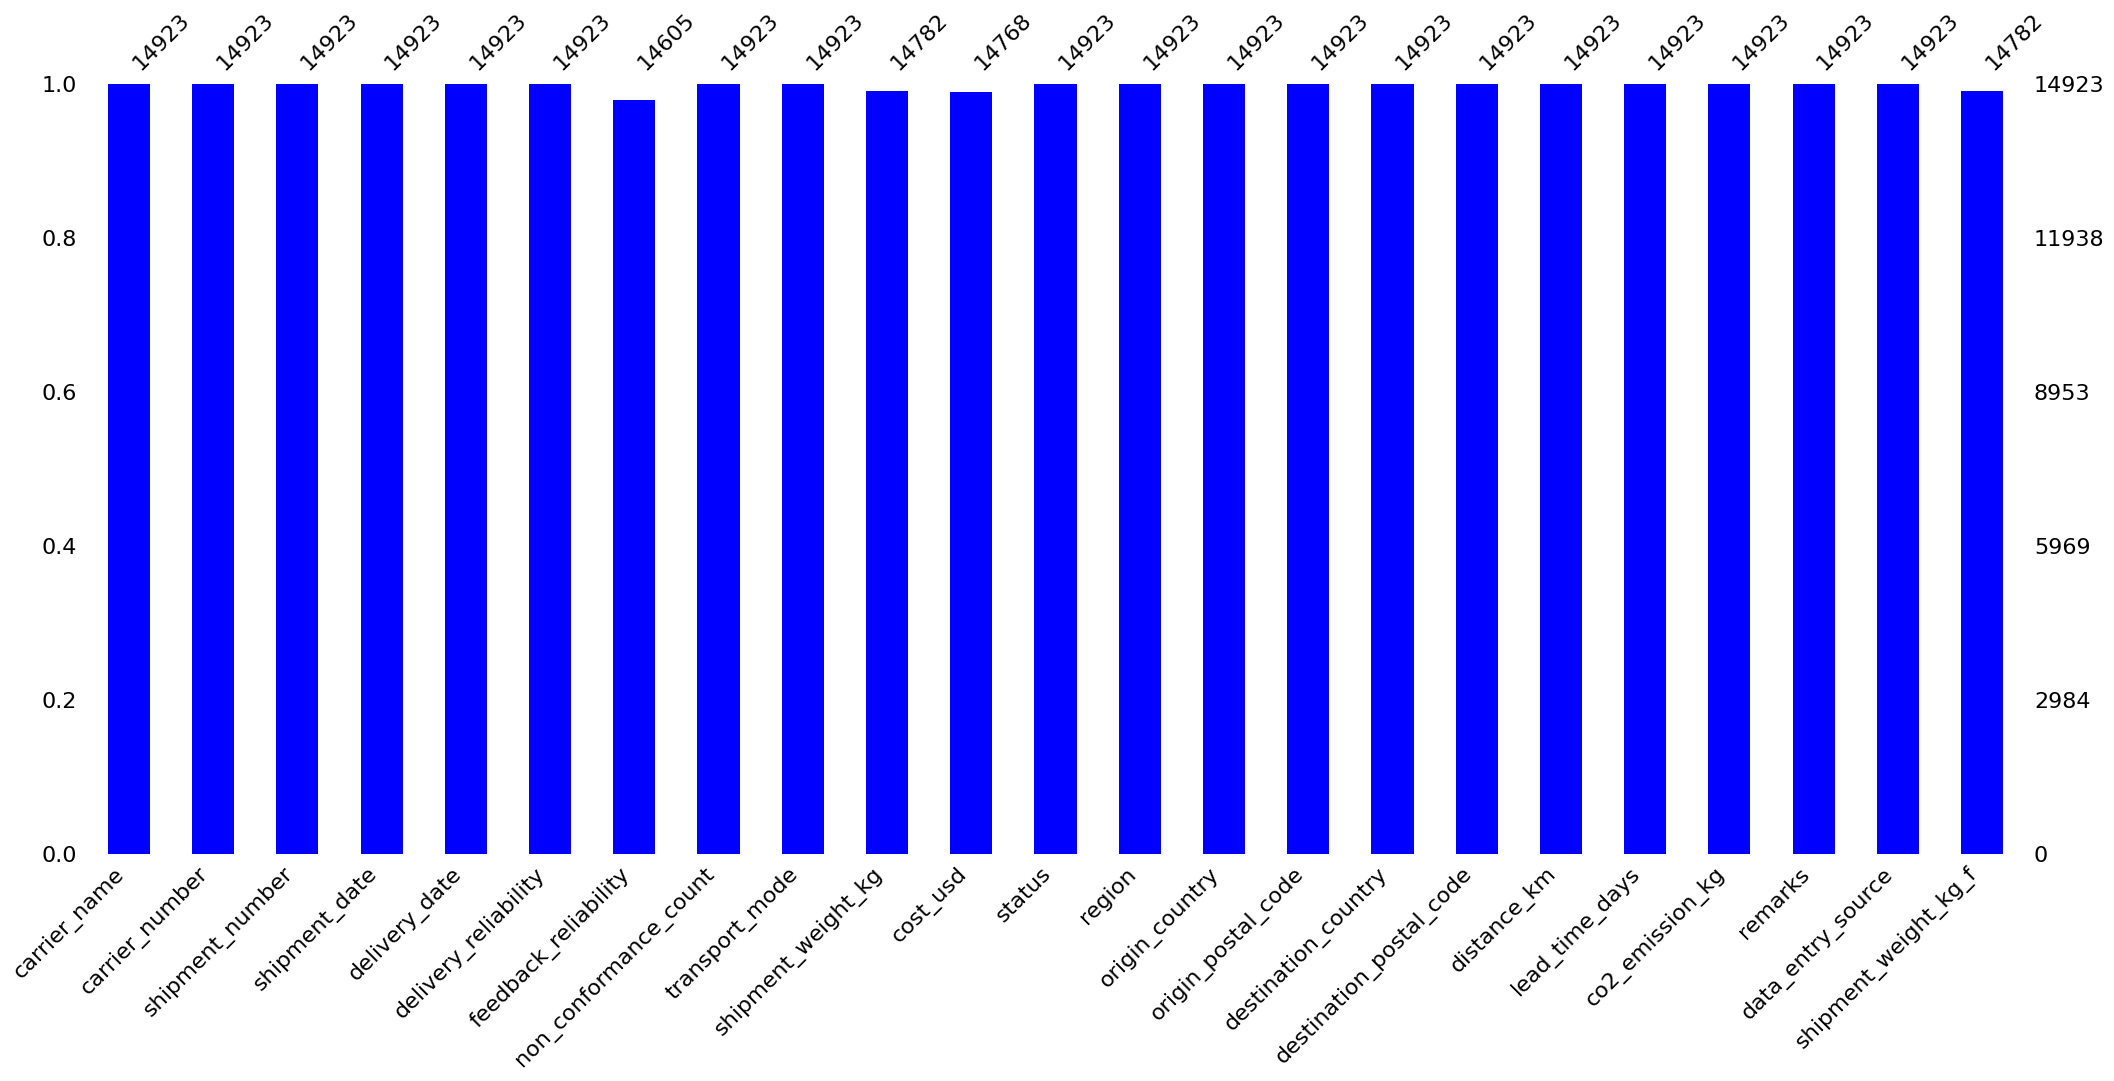

In [631]:
msg.bar(clean_df, color='blue')

Dropping unnecessary columns and dealing with missing values

In [632]:
#dropping the columns and renaming the shipment weight_f column
clean_df = clean_df.drop(['status', 'remarks', 'data_entry_source', 'shipment_weight_kg'], axis='columns').rename(columns={'shipment_weight_kg_f':'shipment_weight_kg'})

In [633]:
clean_df.head()

carrier_name carrier_number shipment_number shipment_date delivery_date delivery_reliability feedback_reliability non_conformance_count  \
0    Hapag-Lloyd       CR-904-C       SHP904437    2023-06-04    2023-06-10                    1                    1                     0   
1          COSCO       CR-533-B       SHP499266    2024-04-07    2024-04-18                    1                    0                     0   
2    Hapag-Lloyd       CR-970-A       SHP227384    2023-09-13    2023-09-16                    1                    0                     0   
3  XPO Logistics         977970       SHP516508    2025-02-15    2025-02-26                   No                    0                     0   
4         Maersk       CR-601-A       SHP976649    2023-06-15    2023-06-19                    1                    1                     0   

  transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
0           Road   7965.47  Latin America             CO              307576                  BR                    76521      5995.28   
1            Sea  20696.89         Africa             ZA              494082                  NG                   577543      7614.42   
2            Air   4455.99           Asia             IN              827682                  JP                   742986      1439.82   
3           Road  30704.21         Europe             SE                5023                  ZA                   850479     11789.43   
4           Road  33841.75  North America             MX               98054                  EG                   771949      5154.71   

   lead_time_days  co2_emission_kg  shipment_weight_kg  
0               6          3556.43             3295.59  
1              11         10062.87            88103.65  
2               3          1295.29             1499.37  
3              11          6589.36             3105.12  
4               4         22588.48            24345.03

<Axes: >

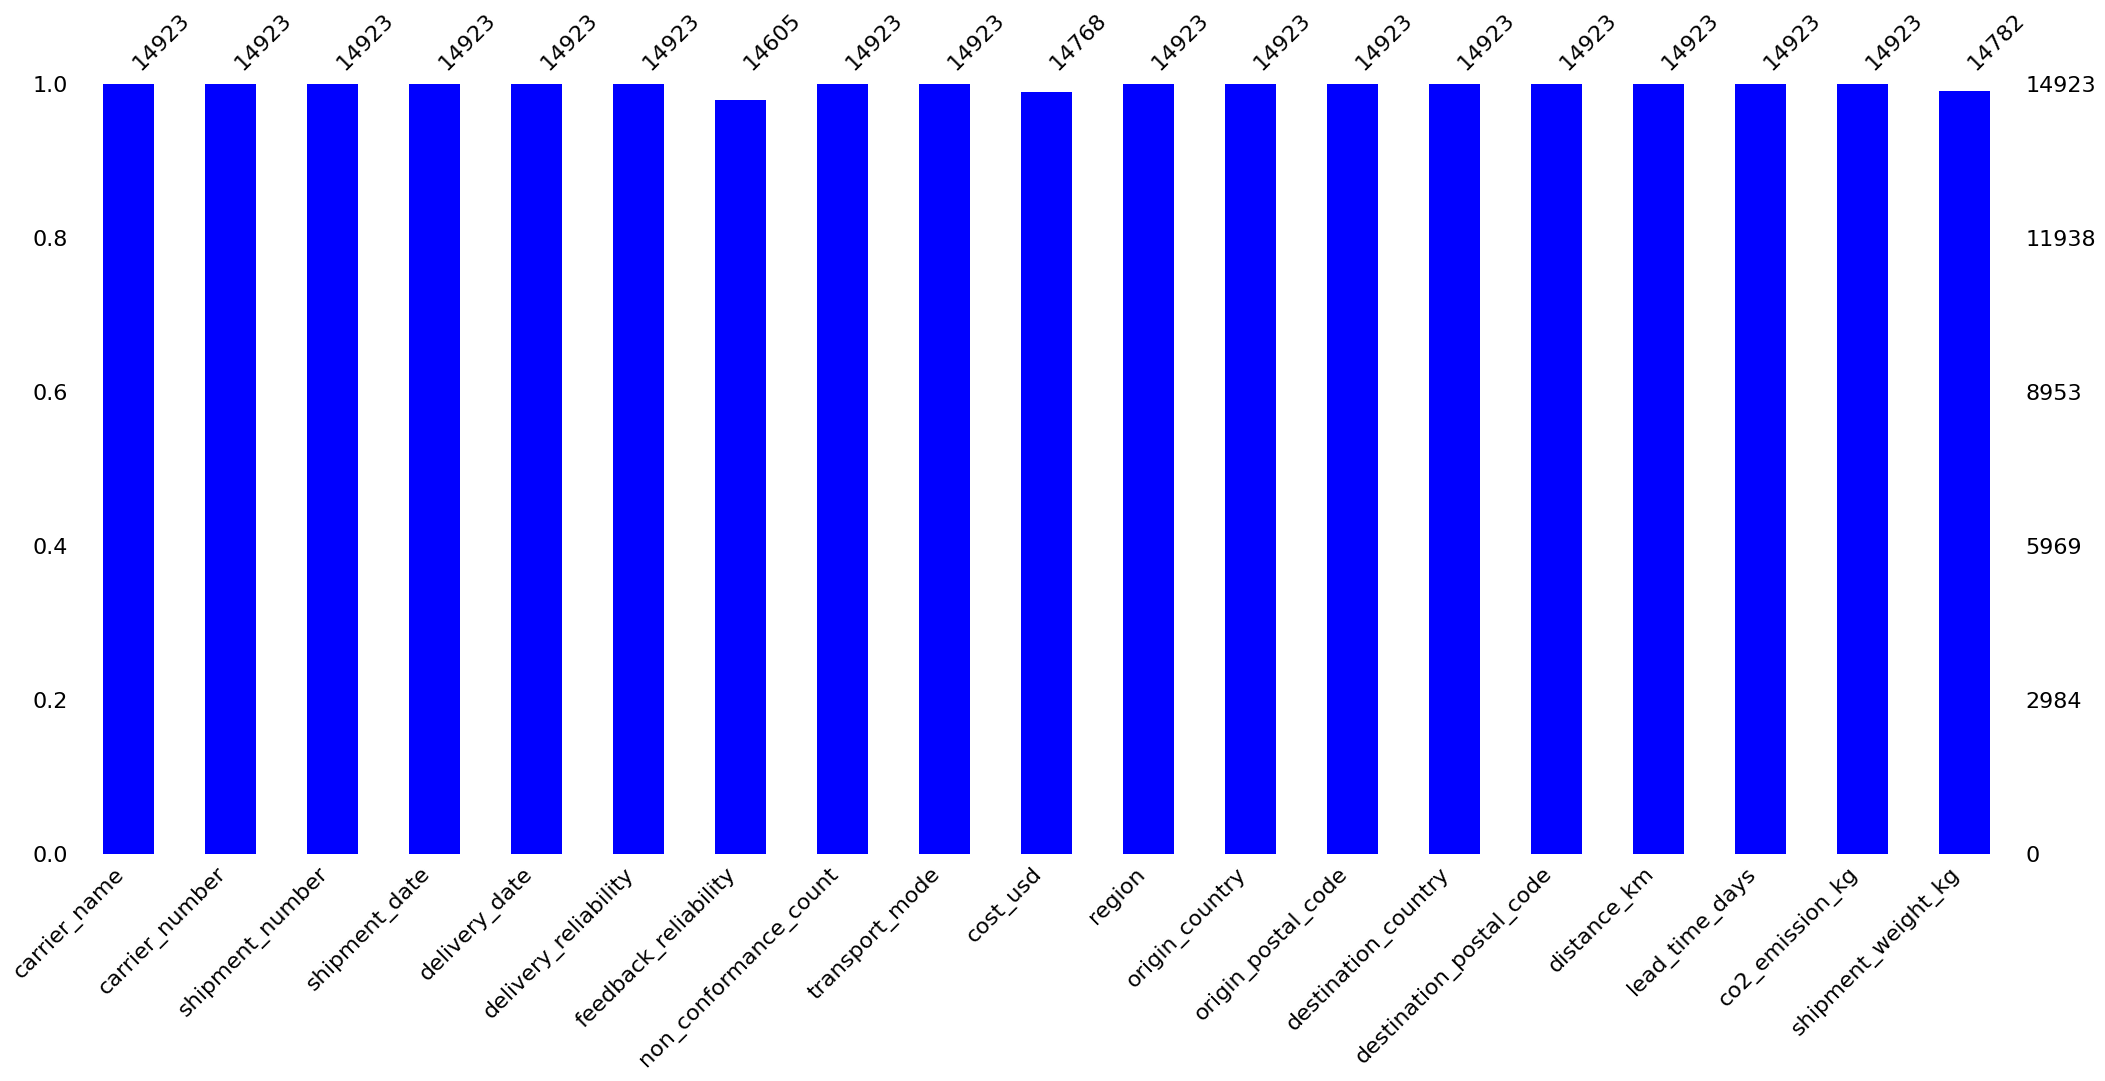

In [634]:
msg.bar(clean_df, color="blue")

Cleaning Feedback Reliability

In [635]:
# checking the state of the unique values in the column
clean_df['feedback_reliability'].unique()

array(['1', '0', 'Provided', nan], dtype=object)

Looks like there are inconsistent formats in the column which must be address

In [636]:
 # setting feedback_reliability to boolean by converting unconventional labelling to 0 or 1, thereby converting string values to INT
clean_df['feedback_reliability'] = np.where(clean_df['feedback_reliability']=="1", 1, np.where(clean_df['feedback_reliability'] == 'Provided', 1, 0))

In [637]:

# spot checks

clean_df['feedback_reliability'].unique()



array([1, 0])

In [638]:
# spot checks
clean_df['feedback_reliability'].isna().sum()

np.int64(0)

Cleaning Delivery Reliability Column

In [639]:
# confirming data type
clean_df['delivery_reliability'].dtype

dtype('O')

In [640]:
# assessing unique values
clean_df['delivery_reliability'].unique()

array(['1', 'No', '0', 'Yes'], dtype=object)

In [641]:
# converting inconstitent labelling into INT(0) or INT(1) as boolean

clean_df['delivery_reliability'] = np.where(clean_df['delivery_reliability'] == "1",1,np.where(clean_df['delivery_reliability'] =="Yes", 1 , 0))

In [642]:
# Spot checks

clean_df['delivery_reliability'].unique()


array([1, 0])

In [643]:
# Spot checks

clean_df['delivery_reliability'].isna().sum()

np.int64(0)

Cleaning Cost USD Column

In [644]:
# Calculating median value of Cost USD

cost_median = clean_df['cost_usd'].median()

cost_median

np.float64(7757.605)

In [645]:
# replacing missing cost values with median cost value


clean_df['cost_usd'] = clean_df['cost_usd'].fillna(cost_median)

In [646]:
# spot checks

clean_df['cost_usd'].isna().sum()

np.int64(0)

<Axes: >

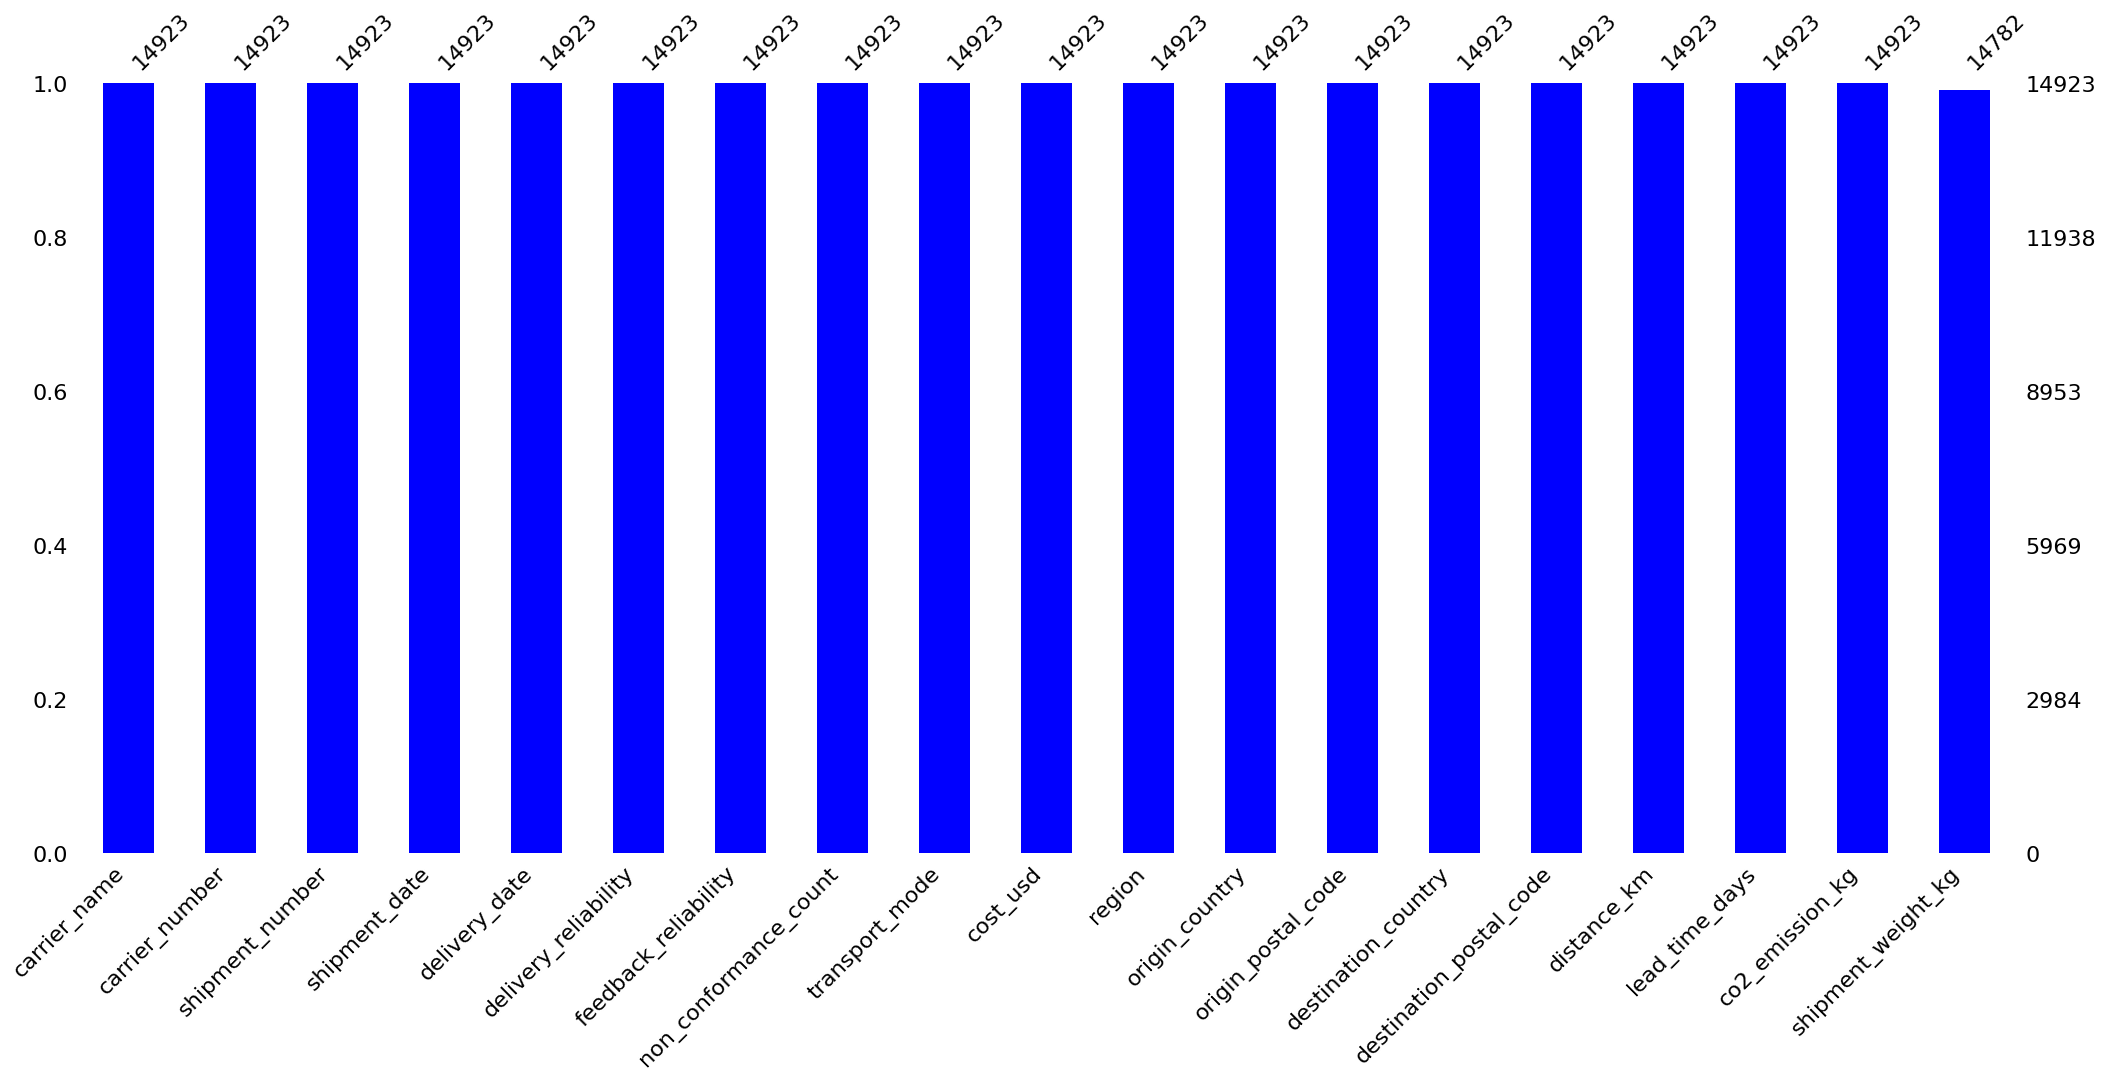

In [647]:
msg.bar(clean_df, color='blue')

In [648]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14923 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   carrier_name             14923 non-null  object        
 1   carrier_number           14923 non-null  object        
 2   shipment_number          14923 non-null  object        
 3   shipment_date            14923 non-null  object        
 4   delivery_date            14923 non-null  datetime64[ns]
 5   delivery_reliability     14923 non-null  int64         
 6   feedback_reliability     14923 non-null  int64         
 7   non_conformance_count    14923 non-null  object        
 8   transport_mode           14923 non-null  object        
 9   cost_usd                 14923 non-null  float64       
 10  region                   14923 non-null  object        
 11  origin_country           14923 non-null  object        
 12  origin_postal_code       14923 non-nu

Cleaning non_conformance_count

In [649]:
clean_df['non_conformance_count'].unique()

array(['0', '2', '3', '1', 'Yes'], dtype=object)

In [650]:
# will convert Yes into 1 

clean_df['non_conformance_count'] = np.where(clean_df['non_conformance_count']== 'Yes', 1, clean_df['non_conformance_count'] )

In [651]:
# and convert the rest into INT values
clean_df['non_conformance_count'] = clean_df['non_conformance_count'].values.astype(int)

In [652]:
#spot checks
clean_df['non_conformance_count'].dtype


dtype('int64')

In [653]:
#spot checks
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14923 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   carrier_name             14923 non-null  object        
 1   carrier_number           14923 non-null  object        
 2   shipment_number          14923 non-null  object        
 3   shipment_date            14923 non-null  object        
 4   delivery_date            14923 non-null  datetime64[ns]
 5   delivery_reliability     14923 non-null  int64         
 6   feedback_reliability     14923 non-null  int64         
 7   non_conformance_count    14923 non-null  int64         
 8   transport_mode           14923 non-null  object        
 9   cost_usd                 14923 non-null  float64       
 10  region                   14923 non-null  object        
 11  origin_country           14923 non-null  object        
 12  origin_postal_code       14923 non-nu

Cleaning up Shipment Weight

In [654]:
#assessing number of missing values
clean_df['shipment_weight_kg'].isna().sum()

np.int64(141)

In [655]:
# calculating median value

weight_median = clean_df['shipment_weight_kg'].median()
weight_median


np.float64(14222.92)

In [656]:
# replacing missing values wih the median value

clean_df['shipment_weight_kg'] = clean_df['shipment_weight_kg'].fillna(weight_median)

In [657]:
# spot check
clean_df['shipment_weight_kg'].isna().sum()

np.int64(0)

In [658]:
clean_df.columns

Index(['carrier_name', 'carrier_number', 'shipment_number', 'shipment_date', 'delivery_date', 'delivery_reliability', 'feedback_reliability',
       'non_conformance_count', 'transport_mode', 'cost_usd', 'region', 'origin_country', 'origin_postal_code', 'destination_country',
       'destination_postal_code', 'distance_km', 'lead_time_days', 'co2_emission_kg', 'shipment_weight_kg'],
      dtype='object')

array([[<Axes: xlabel='cost_usd', ylabel='cost_usd'>,
        <Axes: xlabel='delivery_reliability', ylabel='cost_usd'>,
        <Axes: xlabel='feedback_reliability', ylabel='cost_usd'>,
        <Axes: xlabel='non_conformance_count', ylabel='cost_usd'>,
        <Axes: xlabel='distance_km', ylabel='cost_usd'>,
        <Axes: xlabel='lead_time_days', ylabel='cost_usd'>,
        <Axes: xlabel='co2_emission_kg', ylabel='cost_usd'>,
        <Axes: xlabel='shipment_weight_kg', ylabel='cost_usd'>],
       [<Axes: xlabel='cost_usd', ylabel='delivery_reliability'>,
        <Axes: xlabel='delivery_reliability', ylabel='delivery_reliability'>,
        <Axes: xlabel='feedback_reliability', ylabel='delivery_reliability'>,
        <Axes: xlabel='non_conformance_count', ylabel='delivery_reliability'>,
        <Axes: xlabel='distance_km', ylabel='delivery_reliability'>,
        <Axes: xlabel='lead_time_days', ylabel='delivery_reliability'>,
        <Axes: xlabel='co2_emission_kg', ylabel='delivery_reli

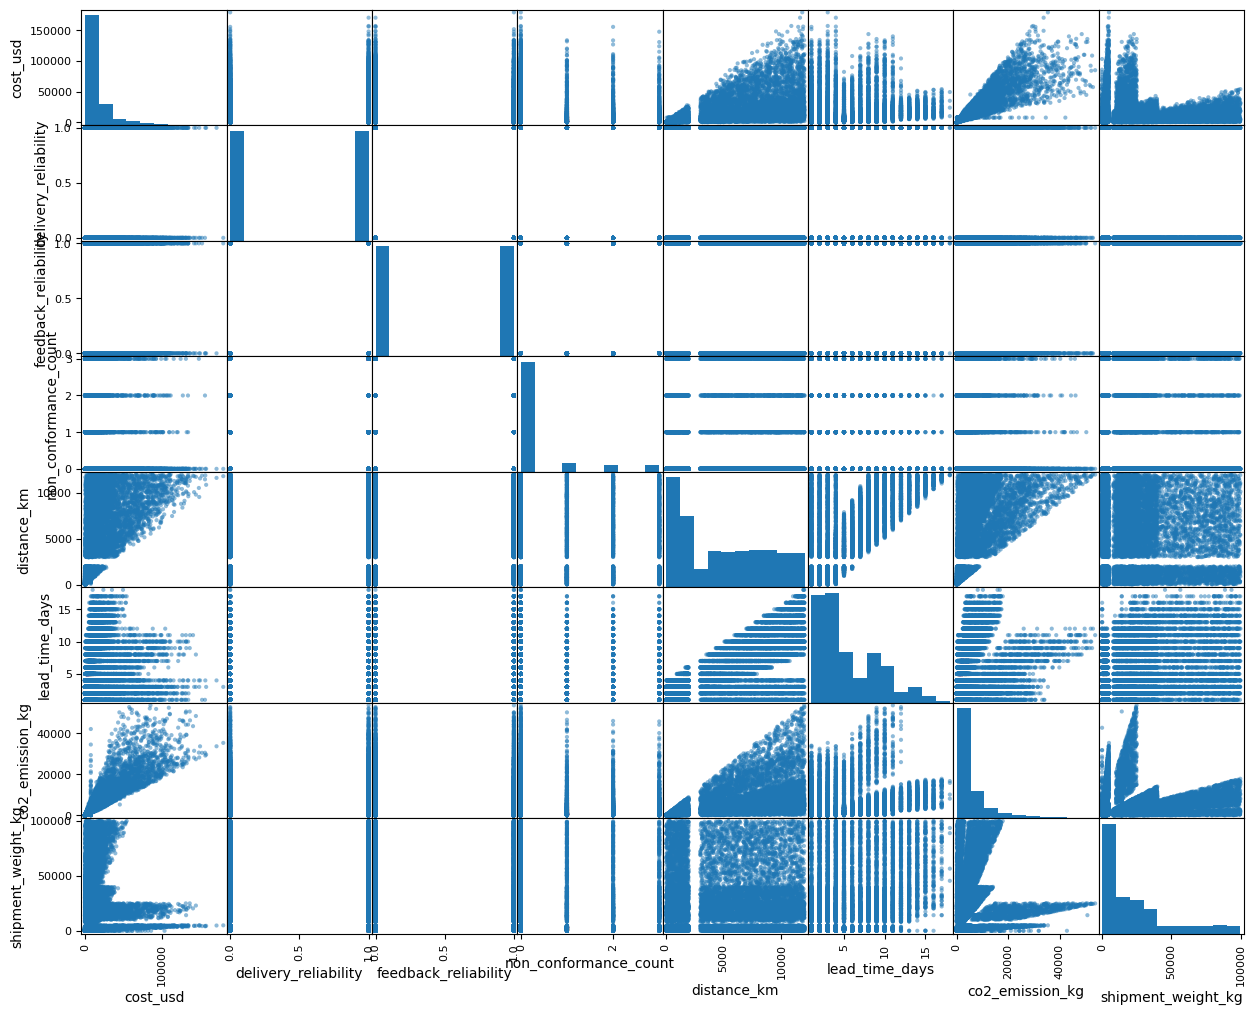

In [659]:
from pandas.plotting import scatter_matrix

scatter_matrix(clean_df[['cost_usd', 'delivery_reliability', 'feedback_reliability', 'non_conformance_count','distance_km','lead_time_days', 'co2_emission_kg','shipment_weight_kg']], figsize=(15,12))

I will explore the data to answer the following:
1. What are the various means of transports?
    ##### a. Statistical Description of each.

In [660]:
# Unique means of transport

print(clean_df['transport_mode'].unique())

['Road' 'Sea' 'Air' 'air' 'Rail' 'sea' 'road' 'air freight' 'rail']


The data for transport mode is inconsistent and require standardization

In [661]:
# selecting the first 4 string values  of each cell value, capitalize the string value and then stripping spaces
clean_df['transport_mode'] = clean_df['transport_mode'].str[:4].str.capitalize().str.strip()

In [662]:
# spot check
clean_df['transport_mode'].unique()

array(['Road', 'Sea', 'Air', 'Rail'], dtype=object)

Number of shipments per transport mode

transport_mode
Road    5197
Sea     3820
Rail    3250
Air     2656
dtype: int64


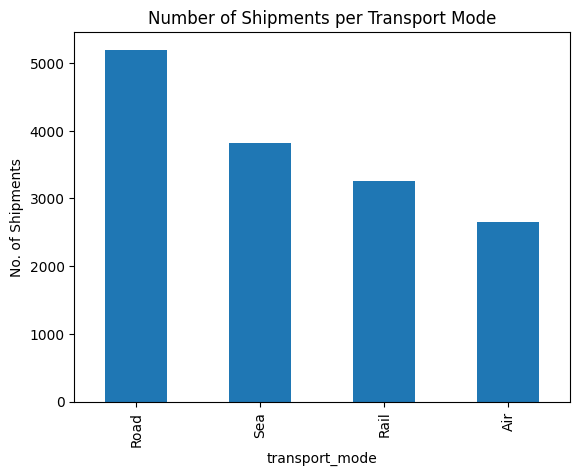

In [663]:
print(clean_df.groupby('transport_mode').size().sort_values(ascending=False))

clean_df.groupby('transport_mode').size().sort_values(ascending=False).plot(kind='bar')
plt.title("Number of Shipments per Transport Mode")
plt.ylabel('No. of Shipments')
plt.show()


5197 of our shipments are by road, followed by sea, rail and air respectively. Let's see if our freight costs are similar to this pattern

                  cost_usd
transport_mode            
Road           76939014.80
Air            75751615.36
Sea            37657750.69
Rail           31682927.49


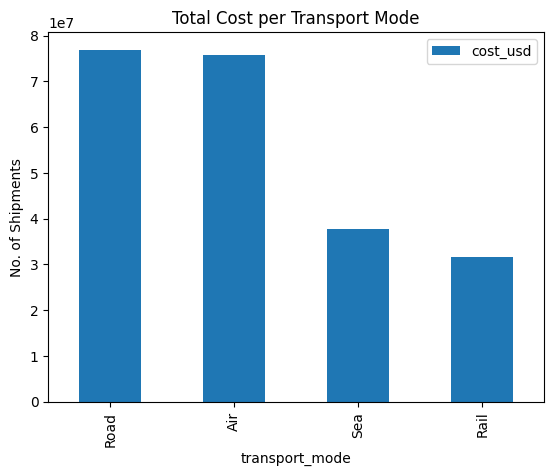

In [664]:
print(clean_df.groupby('transport_mode').aggregate({'cost_usd':'sum'}).sort_values(by='cost_usd', ascending=False))

clean_df.groupby('transport_mode').aggregate({'cost_usd':'sum'}).sort_values(by='cost_usd', ascending=False).plot(kind='bar')
plt.title("Total Cost per Transport Mode")
plt.ylabel('No. of Shipments')
plt.show()

                cost_usd
transport_mode          
Air             28520.94
Road            14804.51
Sea              9858.05
Rail             9748.59


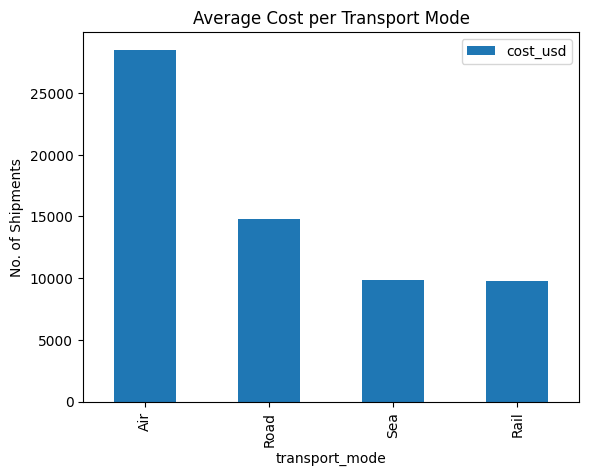

In [665]:
print(clean_df.groupby('transport_mode').aggregate({'cost_usd':'mean'}).sort_values(by='cost_usd', ascending=False))

clean_df.groupby('transport_mode').aggregate({'cost_usd':'mean'}).sort_values(by='cost_usd', ascending=False).plot(kind='bar')
plt.title("Average Cost per Transport Mode")
plt.ylabel('No. of Shipments')
plt.show()

Air is our most expensive mode of transport. 
##### The company should investigate their products that must be transported via Air, can the be transported via sea if possible? if the profit margins are low? 
##### Does it make sense to be investing such expensive freight? Should those products be cut from the offering? 
##### or does it make sense to move some production sites closer to some markets to reduce freight cost?

In [666]:
clean_df.head()

carrier_name carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count  \
0    Hapag-Lloyd       CR-904-C       SHP904437    2023-06-04    2023-06-10                     1                     1                      0   
1          COSCO       CR-533-B       SHP499266    2024-04-07    2024-04-18                     1                     0                      0   
2    Hapag-Lloyd       CR-970-A       SHP227384    2023-09-13    2023-09-16                     1                     0                      0   
3  XPO Logistics         977970       SHP516508    2025-02-15    2025-02-26                     0                     0                      0   
4         Maersk       CR-601-A       SHP976649    2023-06-15    2023-06-19                     1                     1                      0   

  transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
0           Road   7965.47  Latin America             CO              307576                  BR                    76521      5995.28   
1            Sea  20696.89         Africa             ZA              494082                  NG                   577543      7614.42   
2            Air   4455.99           Asia             IN              827682                  JP                   742986      1439.82   
3           Road  30704.21         Europe             SE                5023                  ZA                   850479     11789.43   
4           Road  33841.75  North America             MX               98054                  EG                   771949      5154.71   

   lead_time_days  co2_emission_kg  shipment_weight_kg  
0               6          3556.43             3295.59  
1              11         10062.87            88103.65  
2               3          1295.29             1499.37  
3              11          6589.36             3105.12  
4               4         22588.48            24345.03

Plotting the number of shipments by transport mode

In [667]:
#sort data by delivery date
line_data = clean_df.sort_values(by='delivery_date', ascending=True)

In [668]:
# spot check
line_data.head()

carrier_name carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count  \
9550           UPS       CR-230-B       SHP321086    23-01-2023    2023-01-02                     0                     1                      0   
8428     SFExpress       CR-169-C       SHP119081    2023-01-01    2023-01-02                     0                     0                      3   
14744        COSCO         653814       SHP325371    2023-01-02    2023-01-03                     1                     1                      0   
7929    SF Express         894911       SHP241420    2023-01-01    2023-01-03                     0                     1                      0   
3146          CEVA       CR-167-A       SHP151924    02-01-2023    2023-01-03                     1                     0                      0   

      transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
9550            Rail  15659.61  Latin America             AR              377744                  CL                   468489      8673.02   
8428             Air  24780.90           Asia             CN              925208                  BR                    43675      7686.50   
14744            Air  11152.82         Europe             ES                1111                  DE                     2930      1867.97   
7929            Road    918.23    Middle East             TR                4885                  TR                     7527       583.04   
3146            Rail   2137.02  North America             MX               89417                  CA                    65652      1018.83   

       lead_time_days  co2_emission_kg  shipment_weight_kg  
9550                9          5957.88            22898.14  
8428                1          4479.69              971.33  
14744               1          2027.29             1808.82  
7929                2           172.17             1640.53  
3146                1           857.21            28045.55

In [669]:
#creating a month_year column
line_data['delivery_month_year'] = line_data['delivery_date'].dt.strftime("%Y-%m")

In [670]:
# spot checks
line_data.head()

carrier_name carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count  \
9550           UPS       CR-230-B       SHP321086    23-01-2023    2023-01-02                     0                     1                      0   
8428     SFExpress       CR-169-C       SHP119081    2023-01-01    2023-01-02                     0                     0                      3   
14744        COSCO         653814       SHP325371    2023-01-02    2023-01-03                     1                     1                      0   
7929    SF Express         894911       SHP241420    2023-01-01    2023-01-03                     0                     1                      0   
3146          CEVA       CR-167-A       SHP151924    02-01-2023    2023-01-03                     1                     0                      0   

      transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
9550            Rail  15659.61  Latin America             AR              377744                  CL                   468489      8673.02   
8428             Air  24780.90           Asia             CN              925208                  BR                    43675      7686.50   
14744            Air  11152.82         Europe             ES                1111                  DE                     2930      1867.97   
7929            Road    918.23    Middle East             TR                4885                  TR                     7527       583.04   
3146            Rail   2137.02  North America             MX               89417                  CA                    65652      1018.83   

       lead_time_days  co2_emission_kg  shipment_weight_kg delivery_month_year  
9550                9          5957.88            22898.14             2023-01  
8428                1          4479.69              971.33             2023-01  
14744               1          2027.29             1808.82             2023-01  
7929                2           172.17             1640.53             2023-01  
3146                1           857.21            28045.55             2023-01

In [671]:
# creating a pivot table
line_data_pivot_count = line_data.pivot_table(
    index='delivery_month_year',
    columns='transport_mode',
    values='shipment_number',
    aggfunc='nunique'
)

In [672]:
#spot checks
line_data_pivot_count.head()

transport_mode        Air   Rail   Road    Sea
delivery_month_year                           
2023-01             69.00  83.00 131.00  99.00
2023-02             83.00  86.00 139.00  80.00
2023-03             93.00  98.00 150.00 115.00
2023-04             78.00  97.00 168.00  99.00
2023-05             82.00 108.00 146.00 151.00

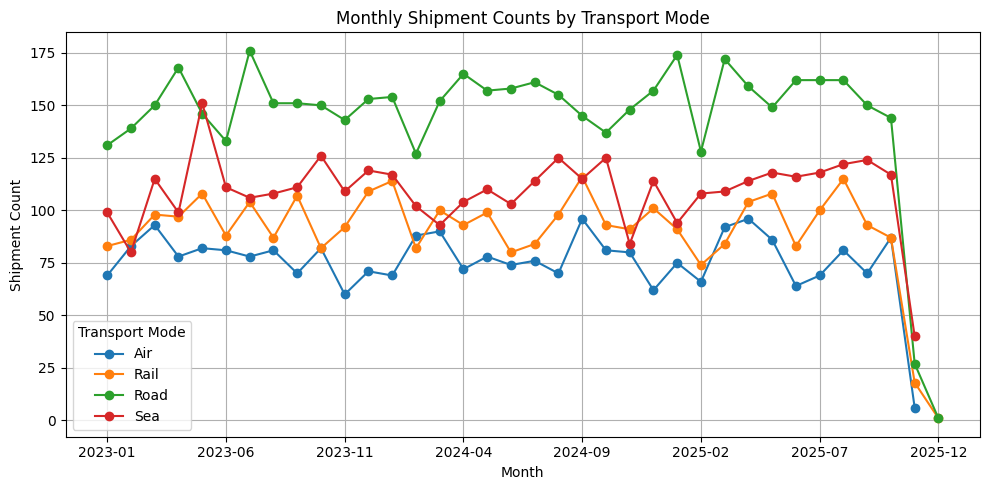

In [673]:
# plotting the line plot
line_data_pivot_count.plot(kind="line", marker="o", figsize=(10, 5))
plt.title("Monthly Shipment Counts by Transport Mode")
plt.xlabel("Month")
plt.ylabel("Shipment Count")
plt.legend(title="Transport Mode")
plt.grid(True)
plt.tight_layout()
plt.show()

Plotting Total Cost of Shipment by Transport mode

In [674]:
line_data_pivot_cost = line_data.pivot_table(
    index='delivery_month_year',
    columns='transport_mode',
    values='cost_usd',
    aggfunc='sum'
)

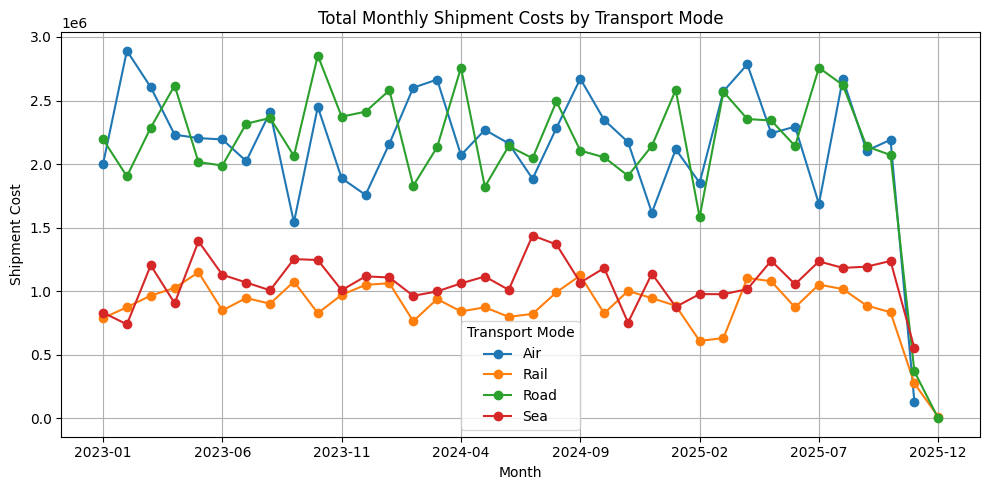

In [675]:
line_data_pivot_cost.plot(kind="line", marker="o", figsize=(10,5))
plt.title("Total Monthly Shipment Costs by Transport Mode")
plt.xlabel("Month")
plt.ylabel("Shipment Cost")
plt.legend(title="Transport Mode")
plt.grid(True)
plt.tight_layout()
plt.show()

Assessing the top carriers by transport mode - number of shipments, costs

In [676]:
# finding the carrier numbers (id) that have inconsistent names
cn =clean_df.groupby('carrier_number').agg({'carrier_name':'nunique'}).reset_index()
cn = cn[cn['carrier_name']>1]

In [677]:
cn

carrier_number  carrier_name
313          220774             2
1657         763155             2
1684         773389             2
1927         868600             2
2259       CR-100-A             6
...             ...           ...
4929       CR-998-B             3
4930       CR-998-C             6
4931       CR-999-A             7
4932       CR-999-B             8
4933       CR-999-C             3

[2548 rows x 2 columns]

Since there are carrier numbers with different variations of the Carriers' name. I will choose the "Max" name of each carrier number and edit them if needed.

In [678]:
clean_df.carrier_number.nunique()

4934

In [679]:
clean_df[clean_df['carrier_number']=='CR-380-C']

carrier_name carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count  \
423     XPO Logistics       CR-380-C       SHP580951    2025-05-15    2025-05-17                     0                     1                      0   
2790          R. Mail       CR-380-C       SHP688332    2025-05-18    2025-05-19                     1                     1                      0   
5235           Rhenus       CR-380-C       SHP743186    2024-09-08    2024-09-14                     0                     0                      0   
7142         DB Cargo       CR-380-C       SHP877006    2025-01-10    2025-01-11                     1                     0                      0   
9331              UPS       CR-380-C       SHP652772    2023-11-25    2023-12-09                     0                     0                      1   
10502           FedEx       CR-380-C          546745    2023-11-12    2023-11-24                     0                     0                      0   
11051     DB Schenker       CR-380-C       SHP165764    2025-04-30    2025-05-01                     0                     0                      0   
11472  Nippon Express       CR-380-C       SHP612076    2024-01-20    2024-01-31                     1                     1                      0   
14999           COSCO       CR-380-C       SHP810996    2023-10-30    2023-11-08                     0                     0                      0   

      transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
423              Air  26087.79         Africa             EG              191651                  NG                   680052      4392.28   
2790            Road    745.64    Middle East             SA              250359                  SA                   147871       385.60   
5235            Road   1645.78    Middle East             TR                8067                  IL                   621670      3900.07   
7142            Road   1136.91  North America             CA               52974                  US                    43638      1384.83   
9331             Sea   9868.02  Latin America             CL              276420                  CO                   349118      8955.32   
10502            Sea  21795.84         Africa             ZA              799891                  NG                   873461      8982.70   
11051            Air  64799.25  Latin America             PE              728262                  CL                   509465      9427.15   
11472           Road  64292.02    Middle East             SA              847532                  CA                    36377     11475.13   
14999           Road   3505.78         Africa             EG              850440                  KE                   397336      8278.25   

       lead_time_days  co2_emission_kg  shipment_weight_kg  
423                 2          9497.81             3603.98  
2790                1           152.03                2.19  
5235                6           967.27             1377.85  
7142                1           243.17              975.54  
9331               14          7503.94            55862.07  
10502              12         11100.22            82382.22  
11051               1         25773.99             4556.70  
11472              11         25068.57            12136.67  
14999               9           902.48              605.66

Looking at the data above, you can tell that the carrier number CR-380-C is associated with multiple carriers. Normally this will be fixed through collaboration with master data owners or ops teams but for the sake of this project, I will choose the first carrier name associated with each carrier number. It will not be the true representation of the business but for the sake of the project let us run with this new reality borne from this data cleaninng technique

In [680]:
first_carrier_name = clean_df.groupby("carrier_number").agg({'carrier_name':'max'}).reset_index()
first_carrier_name



carrier_number    carrier_name
0            101108            USPS
1            101350        DB Cargo
2            101572             UPS
3            101705     db schenker
4            102069  CEVA Logistics
...             ...             ...
4929       CR-998-B             ZIM
4930       CR-998-C   YRC Worldwide
4931       CR-999-A   XPO Logistics
4932       CR-999-B   YRC Worldwide
4933       CR-999-C      SF Express

[4934 rows x 2 columns]

In [681]:
first_carrier_name[first_carrier_name['carrier_number'] == "CR-380-C"]

carrier_number   carrier_name
3090       CR-380-C  XPO Logistics

Even though there are some different variants of how the carrier names are spealt, the carrier numbers are unique and that is what is most important

In [682]:
first_carrier_name.rename(columns={'carrier_name': 'first_carrier_name'}, inplace=True) #renaming the carrier name column

# merging the dataframes

clean_df = pd.merge(clean_df, first_carrier_name, on="carrier_number", how="left")

In [683]:
clean_df.tail()

carrier_name carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count  \
14918   XPO Logistics       CR-951-B       SHP174726    2025-07-05    2025-07-18                     1                     0                      0   
14919        DB Cargo       CR-204-A       SHP328520    2025-07-09    2025-07-10                     0                     1                      0   
14920  CEVA Logistics       CR-379-C       SHP193523    2023-05-14    2023-05-17                     0                     0                      0   
14921             UPS         846087       SHP172566    2024-02-28    2024-03-06                     0                     0                      0   
14922           COSCO       CR-380-C       SHP810996    2023-10-30    2023-11-08                     0                     0                      0   

      transport_mode  cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  \
14918            Sea  27464.13  Latin America             BR               23437                  CL                   447352      9094.26   
14919            Sea    604.98    Middle East             IL              215176                  IL                   787355       119.76   
14920           Rail   2678.16           Asia             SG              850827                  IN                   586907      1676.95   
14921           Road  32891.16         Africa             KE              189208                  NG                   111896      9084.90   
14922           Road   3505.78         Africa             EG              850440                  KE                   397336      8278.25   

       lead_time_days  co2_emission_kg  shipment_weight_kg first_carrier_name  
14918              13         12487.22            91539.19      XPO Logistics  
14919               1           136.97            76246.29     Kuehne + Nagel  
14920               3           455.71             9058.37                ZIM  
14921               7         17238.34            10541.51                UPS  
14922               9           902.48              605.66      XPO Logistics

In [684]:
#dropping the carrier name column

clean_df.drop('carrier_name', axis='columns', inplace=True)

In [685]:
clean_df.head()

carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count transport_mode  \
0       CR-904-C       SHP904437    2023-06-04    2023-06-10                     1                     1                      0           Road   
1       CR-533-B       SHP499266    2024-04-07    2024-04-18                     1                     0                      0            Sea   
2       CR-970-A       SHP227384    2023-09-13    2023-09-16                     1                     0                      0            Air   
3         977970       SHP516508    2025-02-15    2025-02-26                     0                     0                      0           Road   
4       CR-601-A       SHP976649    2023-06-15    2023-06-19                     1                     1                      0           Road   

   cost_usd         region origin_country  origin_postal_code destination_country  destination_postal_code  distance_km  lead_time_days  \
0   7965.47  Latin America             CO              307576                  BR                    76521      5995.28               6   
1  20696.89         Africa             ZA              494082                  NG                   577543      7614.42              11   
2   4455.99           Asia             IN              827682                  JP                   742986      1439.82               3   
3  30704.21         Europe             SE                5023                  ZA                   850479     11789.43              11   
4  33841.75  North America             MX               98054                  EG                   771949      5154.71               4   

   co2_emission_kg  shipment_weight_kg first_carrier_name  
0          3556.43             3295.59          RoyalMail  
1         10062.87            88103.65         Royal Mail  
2          1295.29             1499.37               USPS  
3          6589.36             3105.12      XPO Logistics  
4         22588.48            24345.03               USPS

In [686]:
# creating a new column that concatenates the carrier name and the carrier number

clean_df['carrier_number_name'] = clean_df['carrier_number'] + "-" + clean_df['first_carrier_name']

How many modes of transportation are there?

In [687]:
clean_df['transport_mode'].unique()

array(['Road', 'Sea', 'Air', 'Rail'], dtype=object)

What are the price ranges for each of the modes of transport?

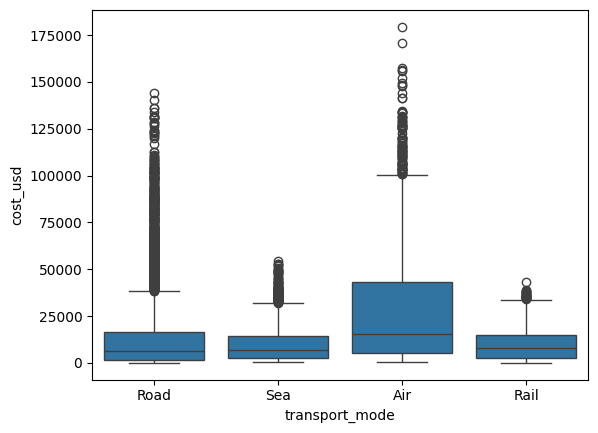

In [688]:
sns.boxplot(data=clean_df, x='transport_mode', y='cost_usd')
plt.show()

Text(0, 0.5, 'cost USD')

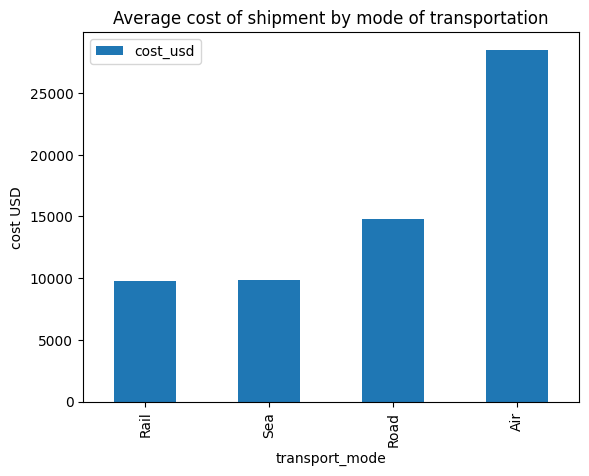

In [689]:
grouped_data_cost = clean_df.groupby('transport_mode').agg({'cost_usd':'mean'}).sort_values(by="cost_usd")

grouped_data_cost.plot(kind="bar")
plt.title("Average cost of shipment by mode of transportation")
plt.ylabel("cost USD")

How Frequently are we using the modes of transport?

Text(0, 0.5, 'Number of Shipments')

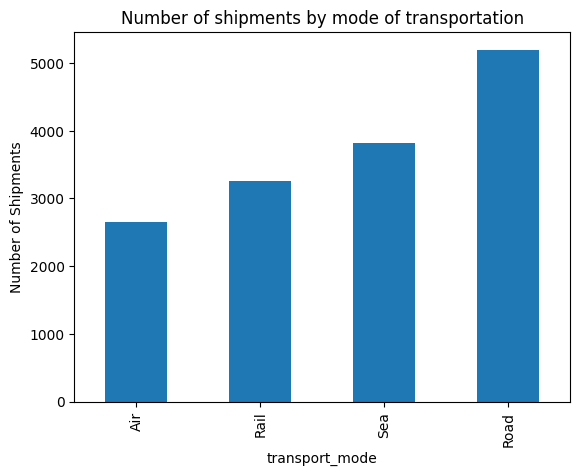

In [690]:
grouped_data_num_shipments = clean_df.groupby('transport_mode').size().sort_values()

grouped_data_num_shipments.plot(kind="bar")
plt.title("Number of shipments by mode of transportation")
plt.ylabel("Number of Shipments")

What are the average weight of goods shipped by mode of transport

Text(0, 0.5, 'Weight KG')

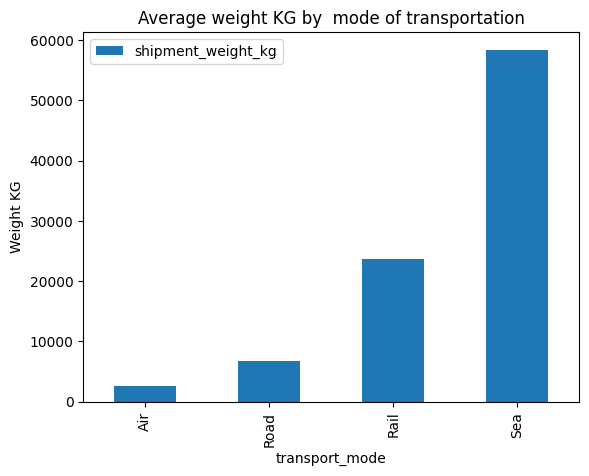

In [691]:
grouped_data_weight = clean_df.groupby('transport_mode').agg({"shipment_weight_kg":"mean"}).sort_values(by="shipment_weight_kg")

grouped_data_weight.plot(kind="bar")
plt.title("Average weight KG by  mode of transportation")
plt.ylabel("Weight KG")

What are the average lead time (days) by shipment type?

Text(0, 0.5, 'lead_time_days')

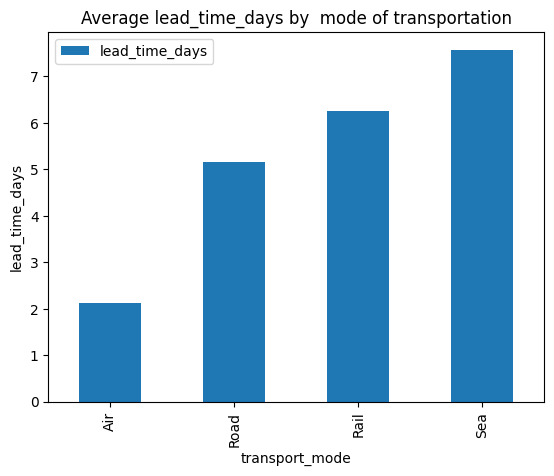

In [692]:
grouped_data_lead_time = clean_df.groupby('transport_mode').agg({"lead_time_days":"mean"}).sort_values(by="lead_time_days")

grouped_data_lead_time.plot(kind="bar")
plt.title("Average lead_time_days by  mode of transportation")
plt.ylabel("lead_time_days")

What are the average emmissions of goods shipped by mode of transport?

Text(0, 0.5, 'co2_emission_kg')

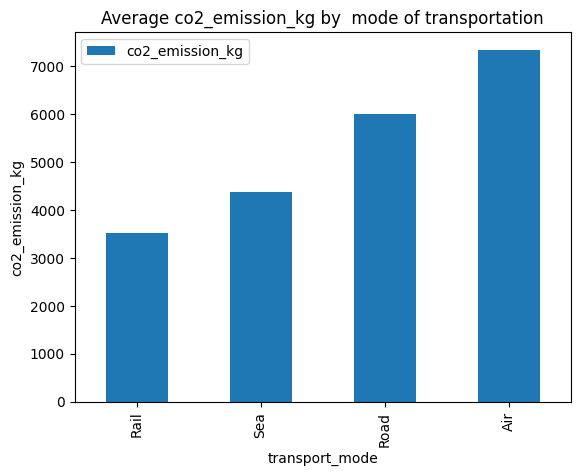

In [693]:
grouped_data_emmissions= clean_df.groupby('transport_mode').agg({"co2_emission_kg":"mean"}).sort_values(by="co2_emission_kg")

grouped_data_emmissions.plot(kind="bar")
plt.title("Average co2_emission_kg by  mode of transportation")
plt.ylabel("co2_emission_kg")

How are the costs and number of shipments trending?

In [694]:
clean_df['year_month'] = clean_df['delivery_date'].dt.to_period("M")

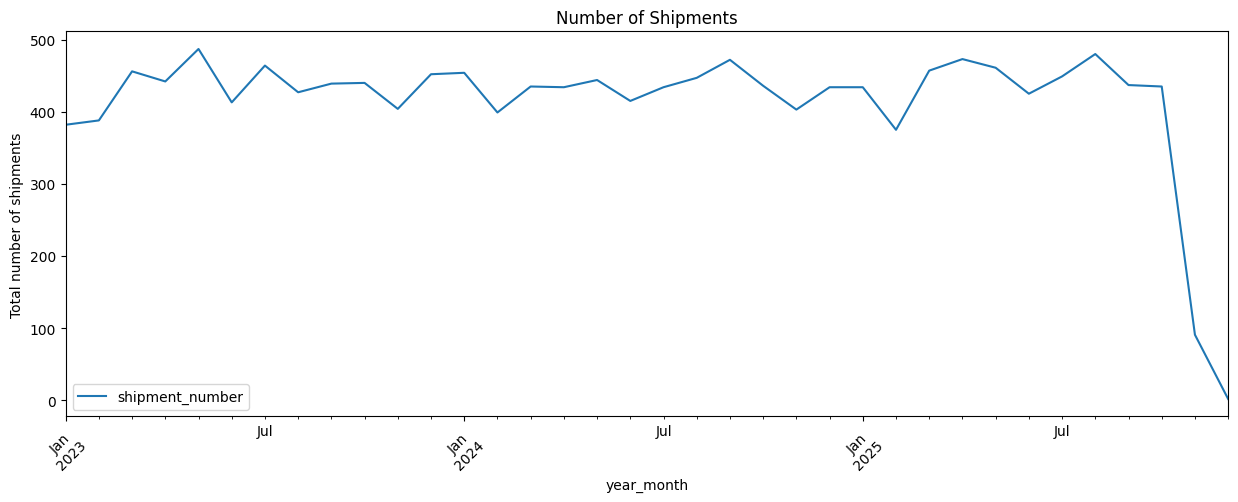

In [695]:
grouped_data_num_shipments = pd.pivot_table(data=clean_df, index="year_month",  values='shipment_number', aggfunc='nunique')

grouped_data_num_shipments.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=45)
plt.title('Number of Shipments')
plt.ylabel('Total number of shipments')
plt.show()

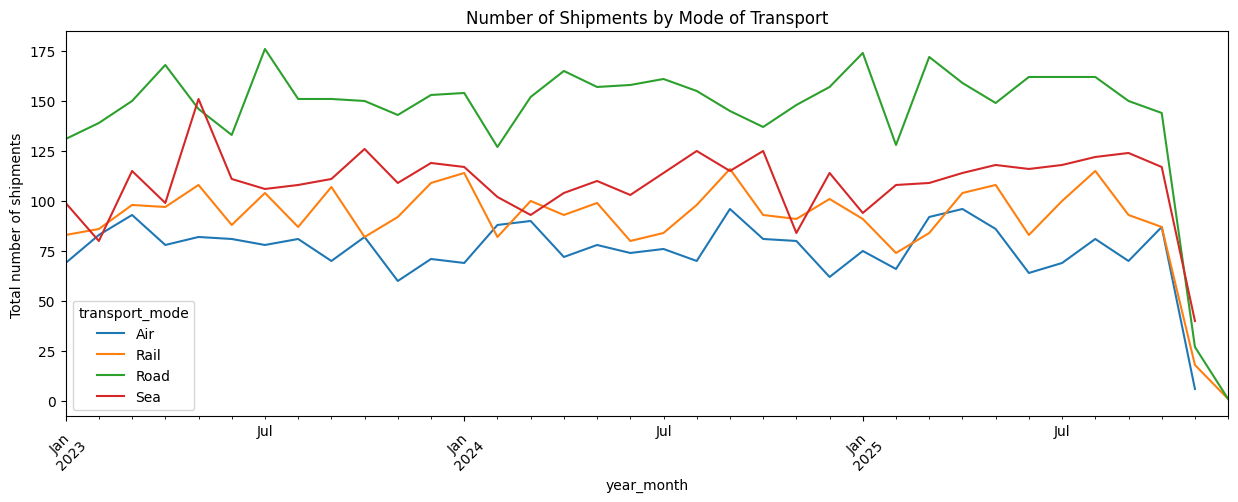

In [696]:
grouped_data_num_shipments = pd.pivot_table(data=clean_df, index="year_month", columns='transport_mode', values='shipment_number', aggfunc='nunique')


grouped_data_num_shipments.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=45)
plt.title('Number of Shipments by Mode of Transport')
plt.ylabel('Total number of shipments')
plt.show()

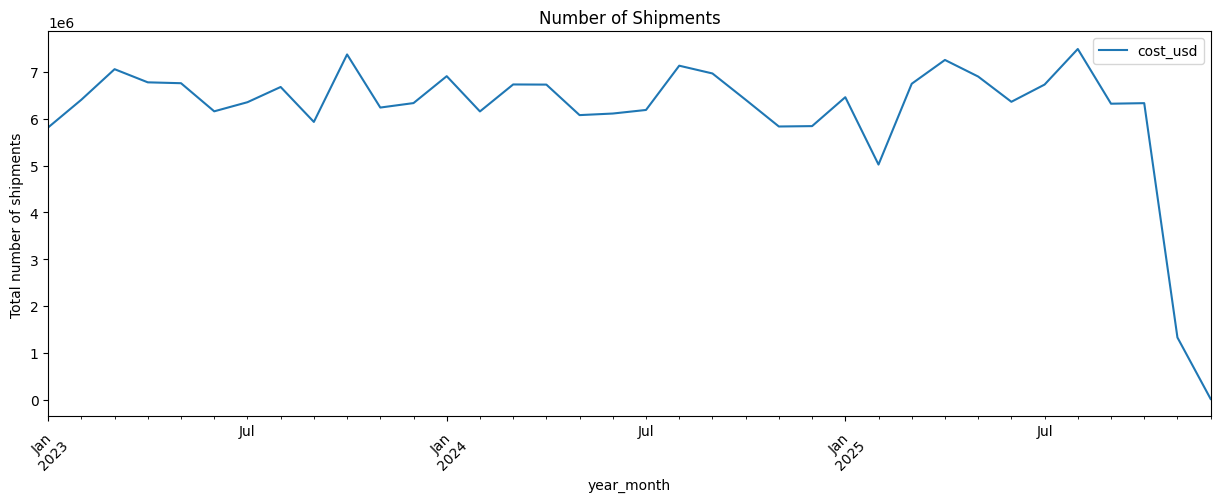

In [697]:
grouped_data_cost = pd.pivot_table(data=clean_df, index="year_month",  values='cost_usd', aggfunc='sum')

grouped_data_cost.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=45)
plt.title('Number of Shipments')
plt.ylabel('Total number of shipments')
plt.show()

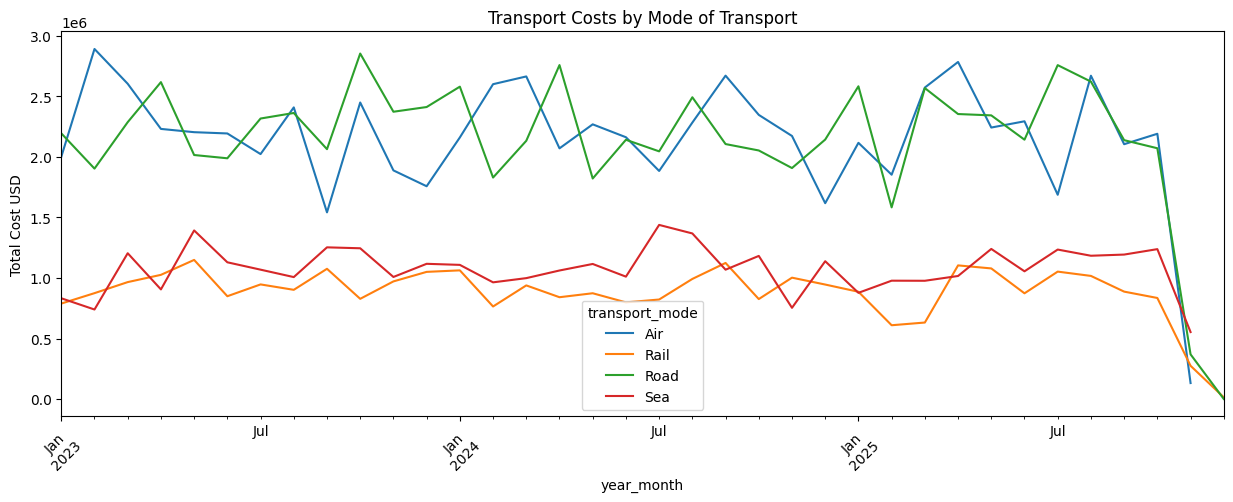

In [698]:
grouped_data_cost = pd.pivot_table(data=clean_df, index="year_month", columns='transport_mode', values='cost_usd', aggfunc='sum')


grouped_data_cost.plot(kind='line', figsize=(15,5))
plt.xticks(rotation=45)
plt.title('Transport Costs by Mode of Transport')
plt.ylabel('Total Cost USD')
plt.show()


Who are the top 20 carriers for the various modes of transportation?

In [699]:
mode_groups_count= {}
mode_groups_cost= {}

for t_mode in list(clean_df['transport_mode'].unique()):
        mode_groups_count[t_mode] = clean_df[clean_df['transport_mode'] == t_mode].groupby('carrier_number_name').size()
        mode_groups_cost[t_mode] = clean_df[clean_df['transport_mode'] == t_mode].groupby('carrier_number_name').agg({"cost_usd": "sum"})


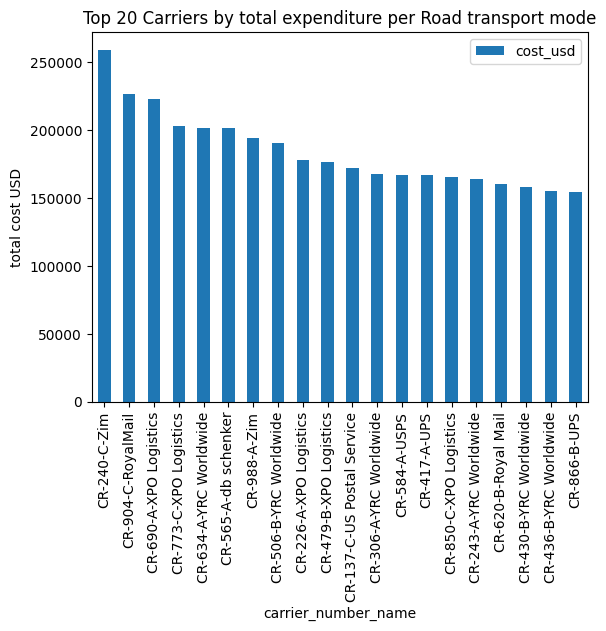

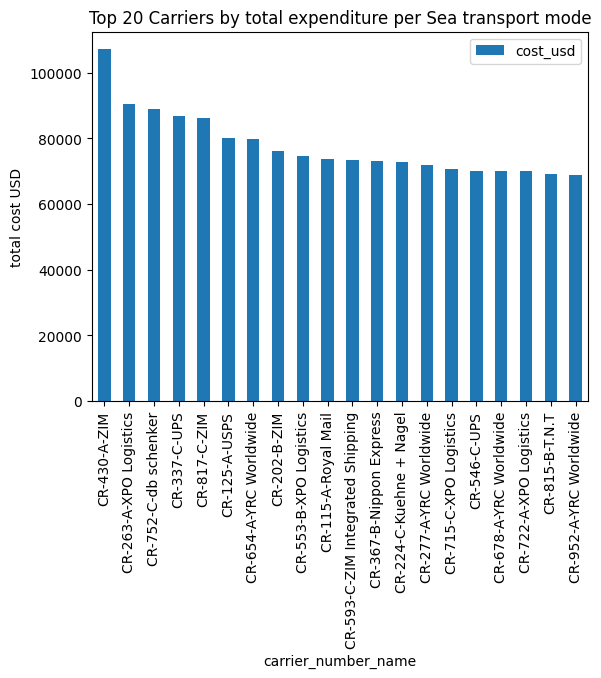

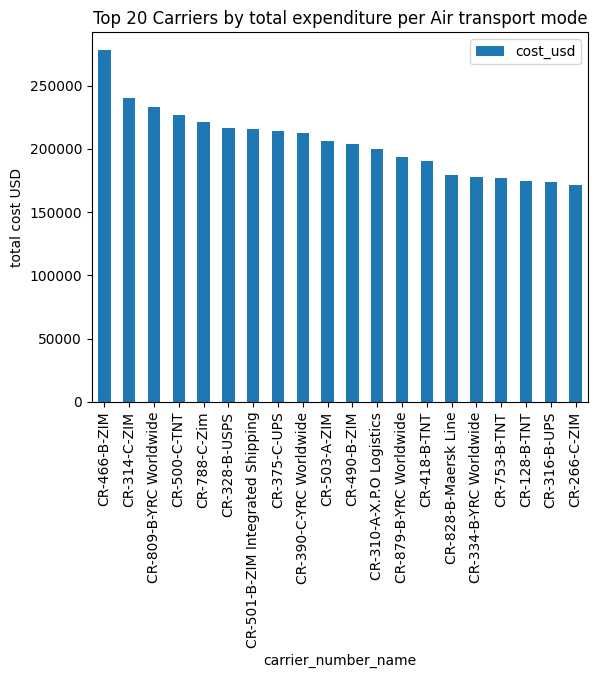

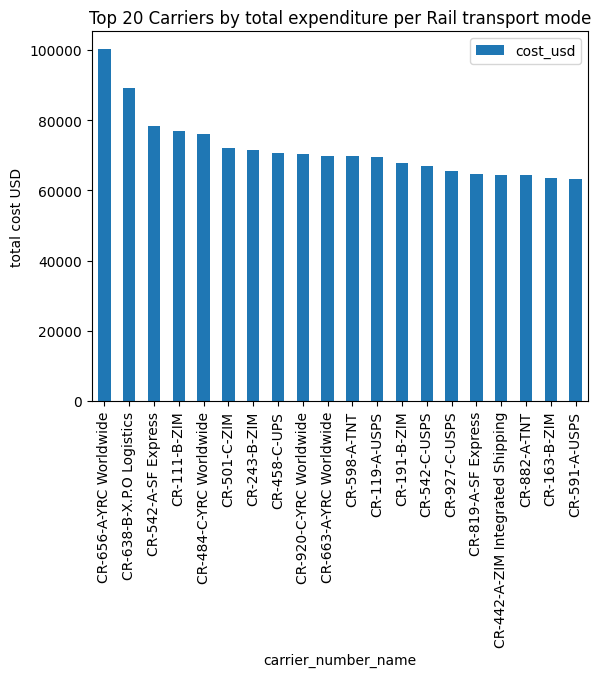

In [700]:
for t_mode in list(clean_df['transport_mode'].unique()):
    mode_groups_cost[t_mode].sort_values(by='cost_usd', ascending=False)[:20].plot(kind='bar')
    plt.title(f'Top 20 Carriers by total expenditure per {t_mode} transport mode')
    plt.ylabel('total cost USD')
    plt.show()

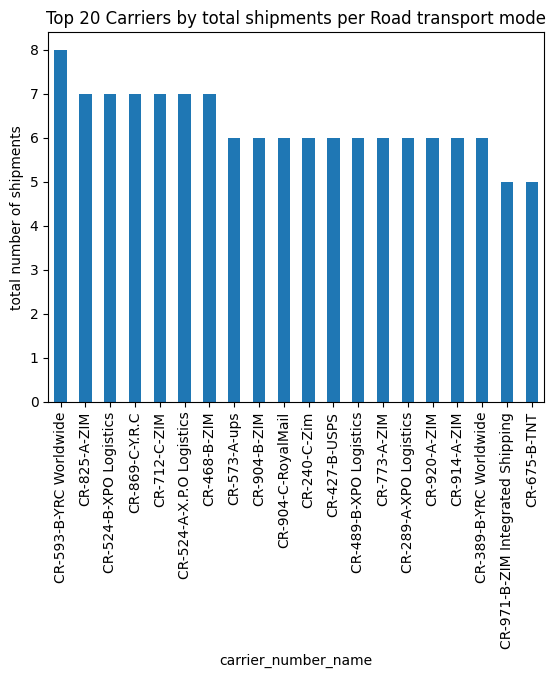

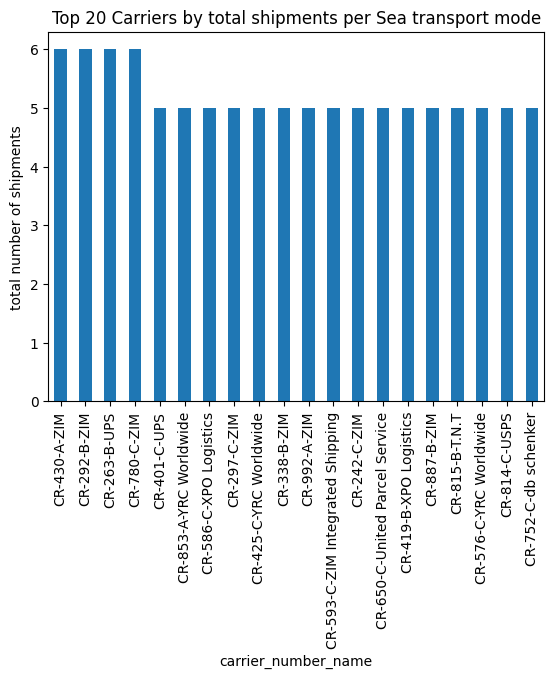

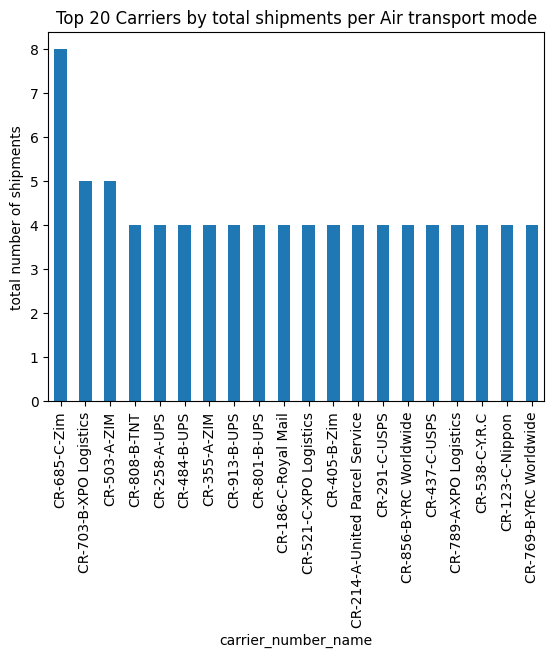

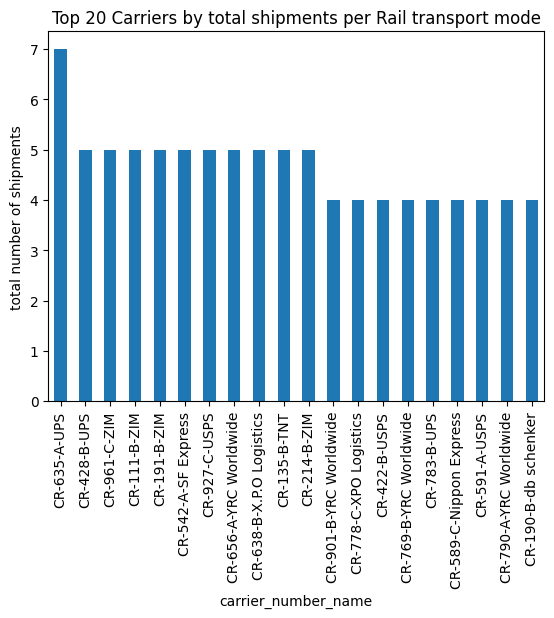

In [701]:
for t_mode in list(clean_df['transport_mode'].unique()):
    mode_groups_count[t_mode].sort_values( ascending=False)[:20].plot(kind='bar')
    plt.title(f'Top 20 Carriers by total shipments per {t_mode} transport mode')
    plt.ylabel('total number of shipments')
    plt.show()

What carriers are charging the highest price per distance for the transport modes?

In [702]:
clean_df['price_per_distance'] = clean_df['distance_km']/clean_df['cost_usd']

In [703]:
clean_df.head()

carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count transport_mode  \
0       CR-904-C       SHP904437    2023-06-04    2023-06-10                     1                     1                      0           Road   
1       CR-533-B       SHP499266    2024-04-07    2024-04-18                     1                     0                      0            Sea   
2       CR-970-A       SHP227384    2023-09-13    2023-09-16                     1                     0                      0            Air   
3         977970       SHP516508    2025-02-15    2025-02-26                     0                     0                      0           Road   
4       CR-601-A       SHP976649    2023-06-15    2023-06-19                     1                     1                      0           Road   

   cost_usd         region  ... destination_country  destination_postal_code distance_km  lead_time_days  co2_emission_kg  shipment_weight_kg  \
0   7965.47  Latin America  ...                  BR                    76521     5995.28               6          3556.43             3295.59   
1  20696.89         Africa  ...                  NG                   577543     7614.42              11         10062.87            88103.65   
2   4455.99           Asia  ...                  JP                   742986     1439.82               3          1295.29             1499.37   
3  30704.21         Europe  ...                  ZA                   850479    11789.43              11          6589.36             3105.12   
4  33841.75  North America  ...                  EG                   771949     5154.71               4         22588.48            24345.03   

   first_carrier_name   carrier_number_name year_month price_per_distance  
0           RoyalMail    CR-904-C-RoyalMail    2023-06               0.75  
1          Royal Mail   CR-533-B-Royal Mail    2024-04               0.37  
2                USPS         CR-970-A-USPS    2023-09               0.32  
3       XPO Logistics  977970-XPO Logistics    2025-02               0.38  
4                USPS         CR-601-A-USPS    2023-06               0.15  

[5 rows x 22 columns]

In [704]:

mode_groups_cost_km= {}

for t_mode in list(clean_df['transport_mode'].unique()):
        mode_groups_cost_km[t_mode] = clean_df[clean_df['transport_mode'] == t_mode].groupby('carrier_number_name').agg({"price_per_distance": "mean"})

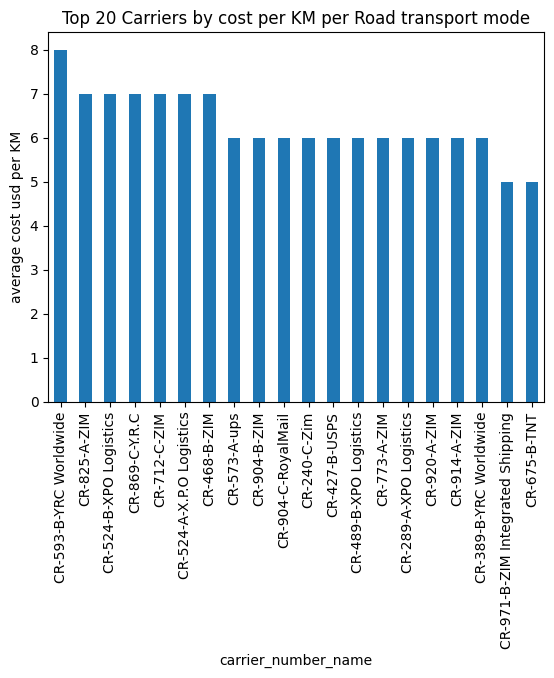

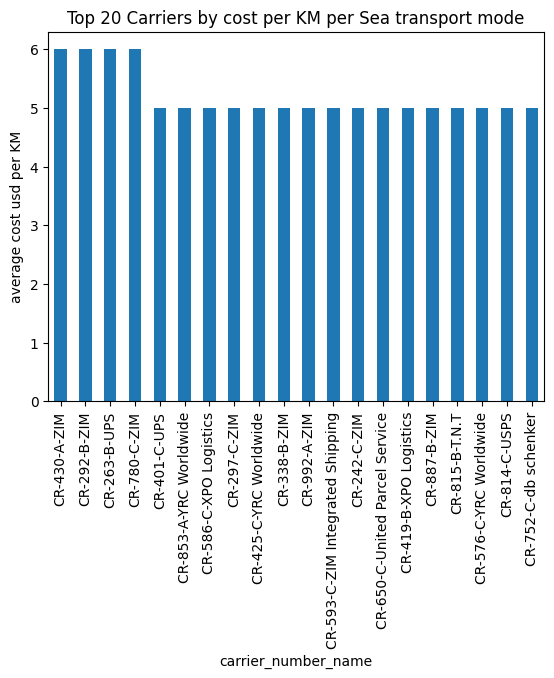

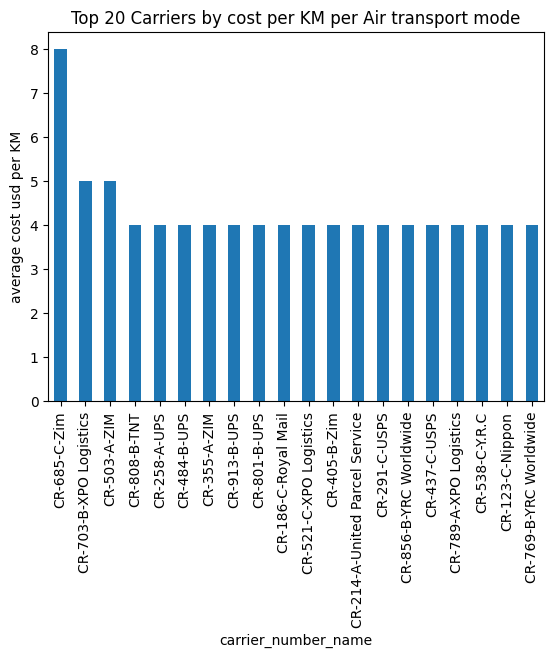

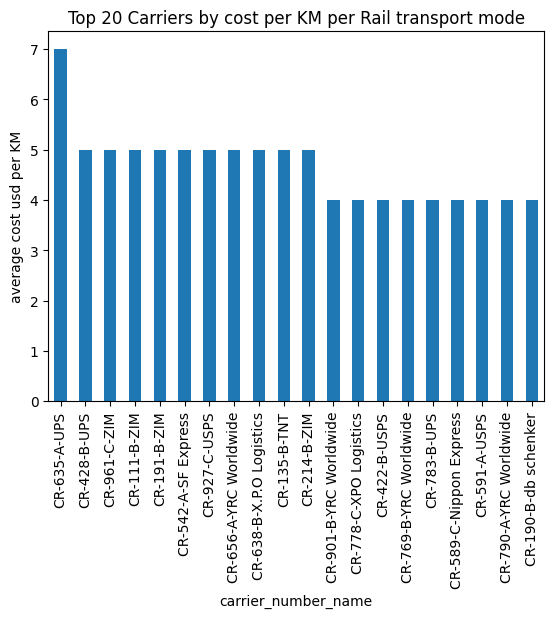

In [705]:
for t_mode in list(clean_df['transport_mode'].unique()):
    mode_groups_count[t_mode].sort_values( ascending=False)[:20].plot(kind='bar')
    plt.title(f'Top 20 Carriers by cost per KM per {t_mode} transport mode')
    plt.ylabel('average cost usd per KM')
    plt.show()

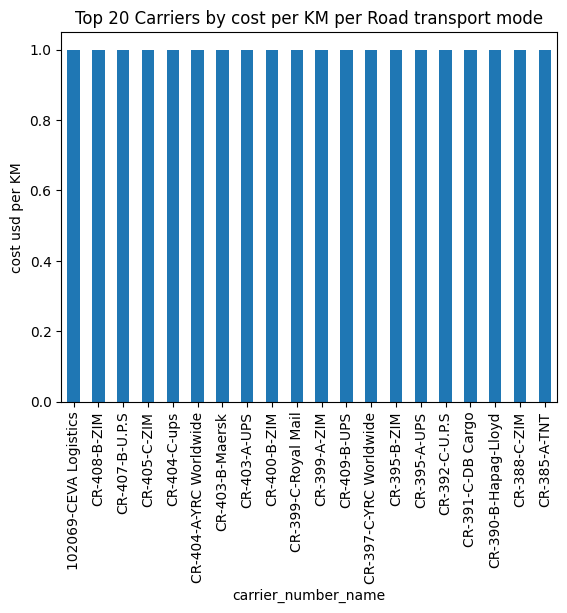

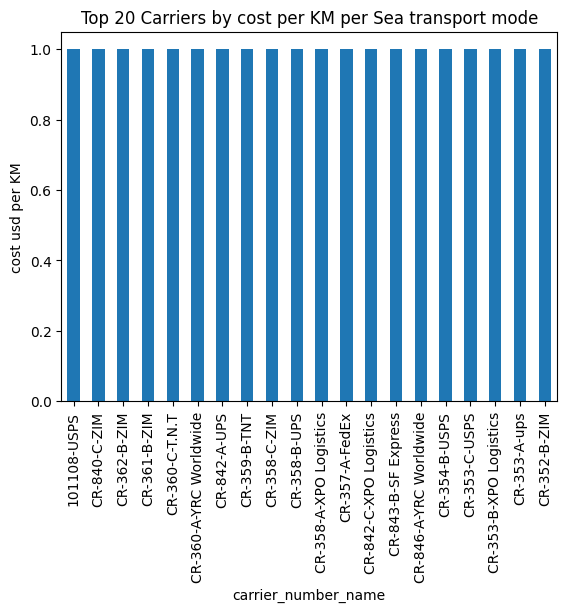

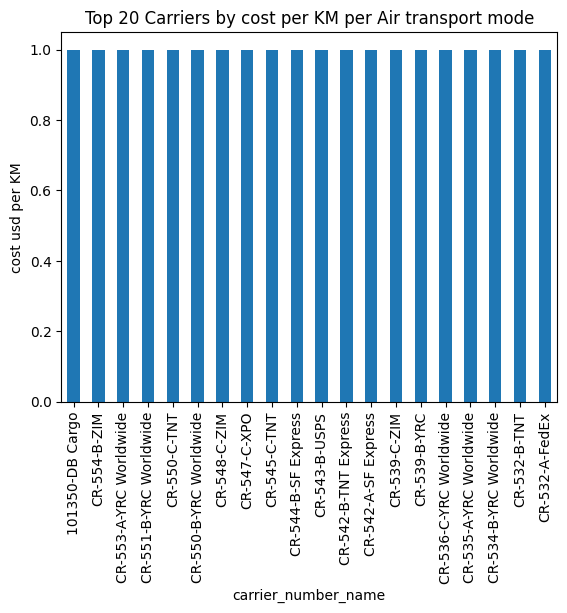

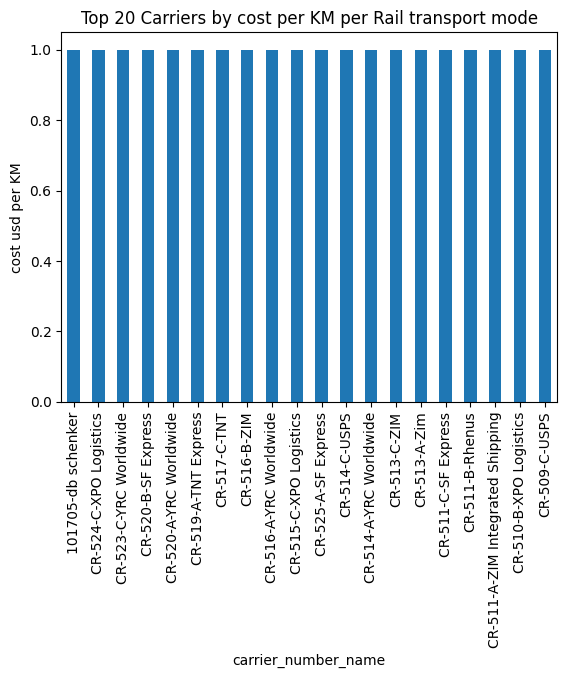

In [706]:
for t_mode in list(clean_df['transport_mode'].unique()):
    mode_groups_count[t_mode].sort_values( ascending=True)[:20].plot(kind='bar')
    plt.title(f'Top 20 Carriers by cost per KM per {t_mode} transport mode')
    plt.ylabel('cost usd per KM')
    plt.show()

Carrier Feedback Reliability

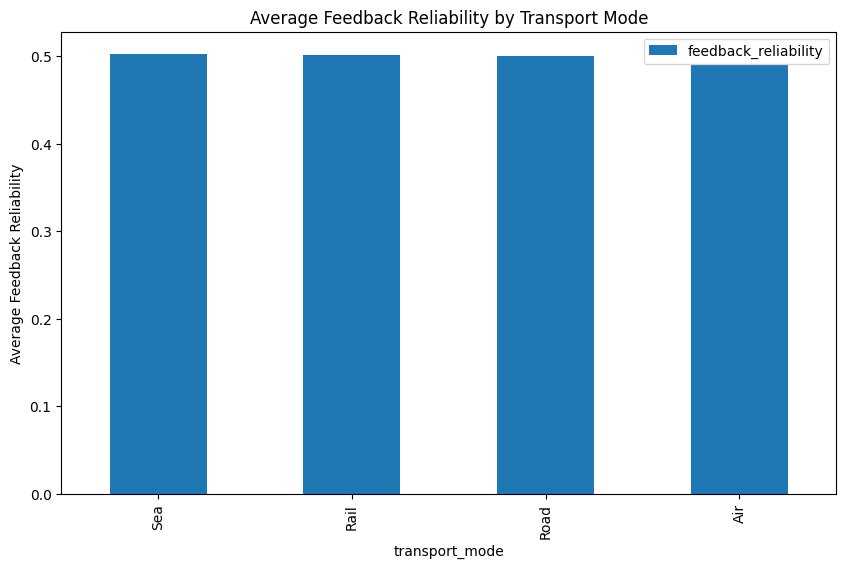

In [735]:
clean_df.groupby("transport_mode").agg({'feedback_reliability':'mean'}).reset_index().sort_values(by='feedback_reliability', ascending=False).plot(kind='bar', x='transport_mode',figsize=(10,6))
plt.ylabel('Average Feedback Reliability')
plt.title('Average Feedback Reliability by Transport Mode')
plt.show()

Top 20 Communicative Carriers

In [736]:
clean_df.groupby("carrier_number_name").agg({'feedback_reliability':'mean'}).reset_index()

carrier_number_name  feedback_reliability
0                101108-USPS                  0.00
1            101350-DB Cargo                  0.00
2                 101572-UPS                  1.00
3         101705-db schenker                  0.00
4      102069-CEVA Logistics                  0.00
...                      ...                   ...
4929            CR-998-B-ZIM                  1.00
4930  CR-998-C-YRC Worldwide                  0.50
4931  CR-999-A-XPO Logistics                  0.38
4932  CR-999-B-YRC Worldwide                  0.88
4933     CR-999-C-SF Express                  0.67

[4934 rows x 2 columns]

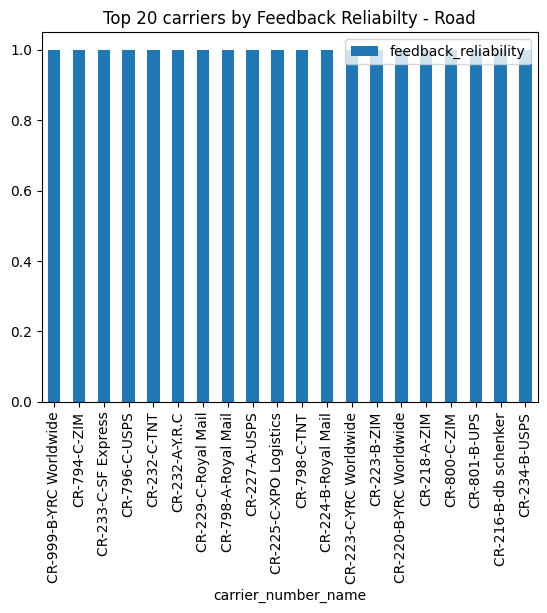

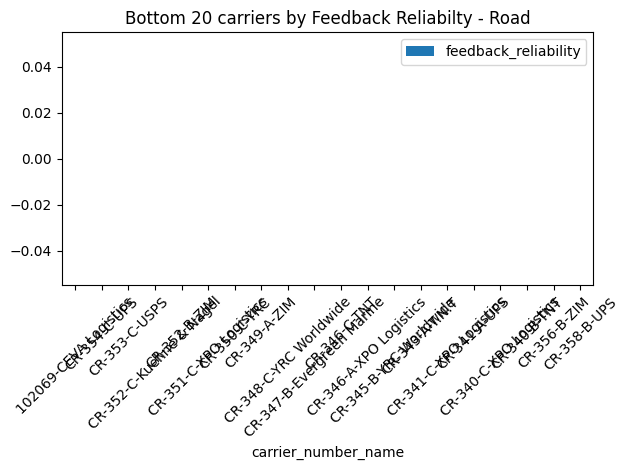

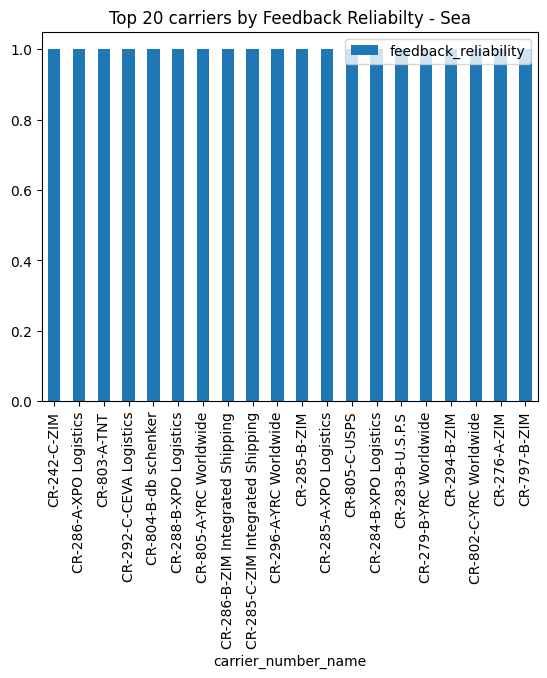

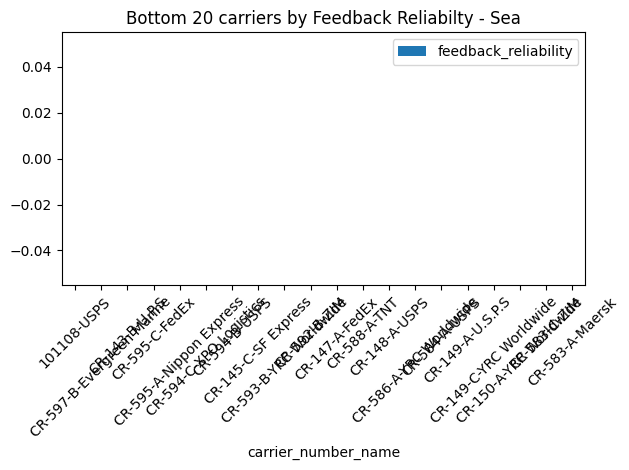

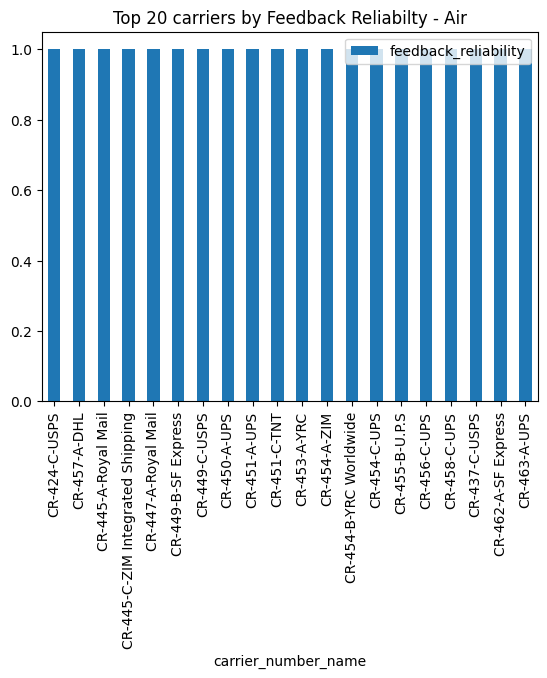

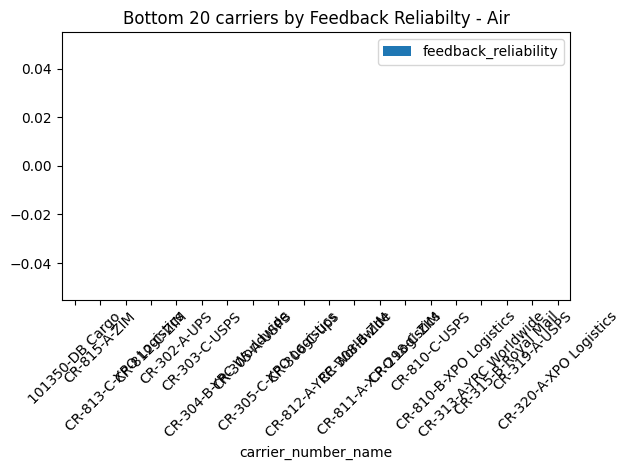

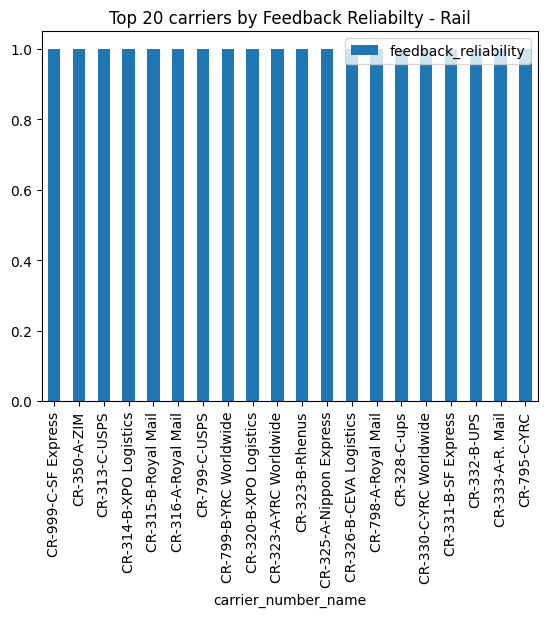

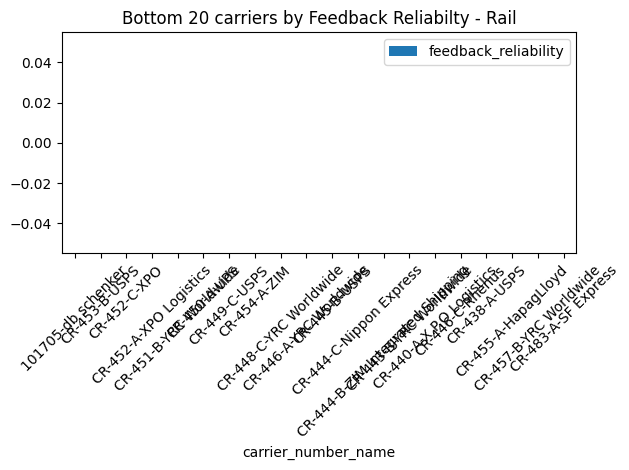

In [737]:
top_average_feedback_reliability = {}
bottom_average_feedback_reliability = {}


for mode in list(clean_df['transport_mode'].unique()):
    top_average_feedback_reliability[mode] = clean_df[clean_df['transport_mode'] == mode].groupby("carrier_number_name").agg({'feedback_reliability':'mean'}).reset_index().sort_values(by="feedback_reliability", ascending=False)[:20]
    bottom_average_feedback_reliability[mode] = clean_df[clean_df['transport_mode'] == mode].groupby("carrier_number_name").agg({'feedback_reliability':'mean'}).reset_index().sort_values(by="feedback_reliability", ascending=True)[:20]
    top_average_feedback_reliability[mode].plot(kind='bar',  x='carrier_number_name')
    plt.title(f'Top 20 carriers by Feedback Reliabilty - {mode}')
    bottom_average_feedback_reliability[mode].plot(kind='bar', x='carrier_number_name')
    plt.title(f'Bottom 20 carriers by Feedback Reliabilty - {mode}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Carrier Delivery Reliability

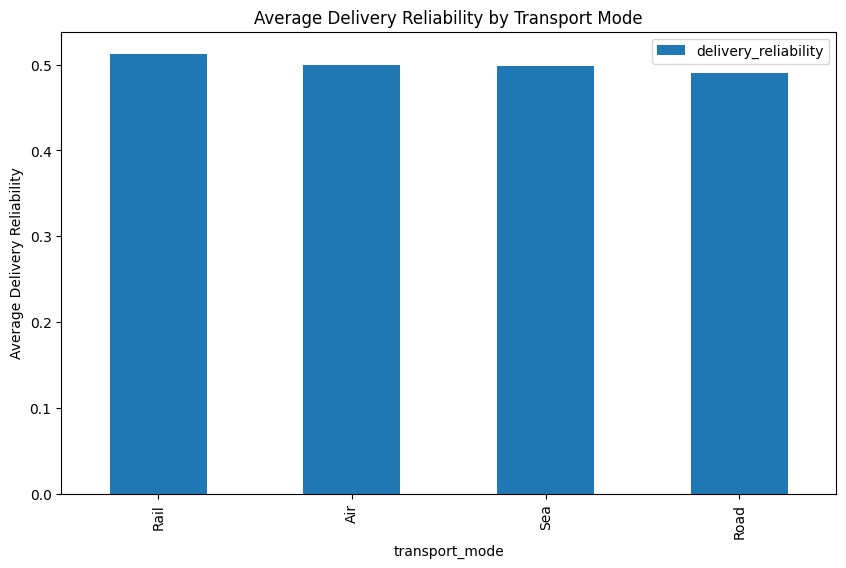

In [707]:
clean_df.groupby("transport_mode").agg({'delivery_reliability':'mean'}).reset_index().sort_values(by='delivery_reliability', ascending=False).plot(kind='bar', x='transport_mode',figsize=(10,6))
plt.ylabel('Average Delivery Reliability')
plt.title('Average Delivery Reliability by Transport Mode')
plt.show()

Top 20 reliable carriers

In [708]:
clean_df.groupby("carrier_number_name").agg({'delivery_reliability':'mean'}).reset_index()

carrier_number_name  delivery_reliability
0                101108-USPS                  1.00
1            101350-DB Cargo                  1.00
2                 101572-UPS                  0.00
3         101705-db schenker                  0.00
4      102069-CEVA Logistics                  1.00
...                      ...                   ...
4929            CR-998-B-ZIM                  0.67
4930  CR-998-C-YRC Worldwide                  0.50
4931  CR-999-A-XPO Logistics                  0.38
4932  CR-999-B-YRC Worldwide                  0.38
4933     CR-999-C-SF Express                  0.33

[4934 rows x 2 columns]

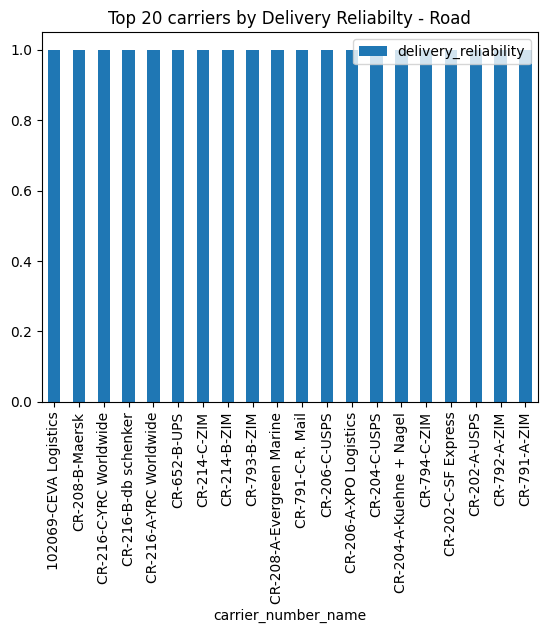

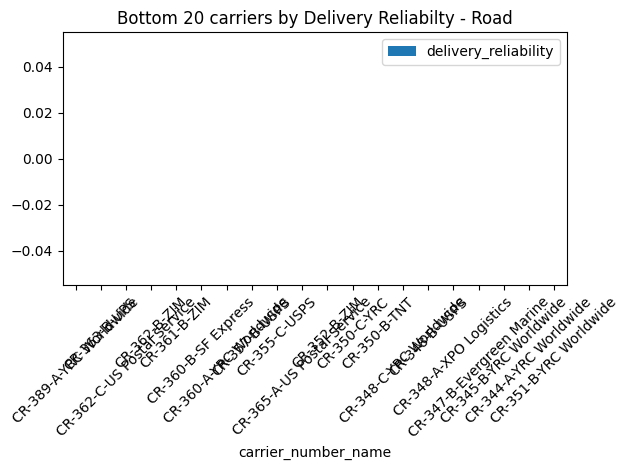

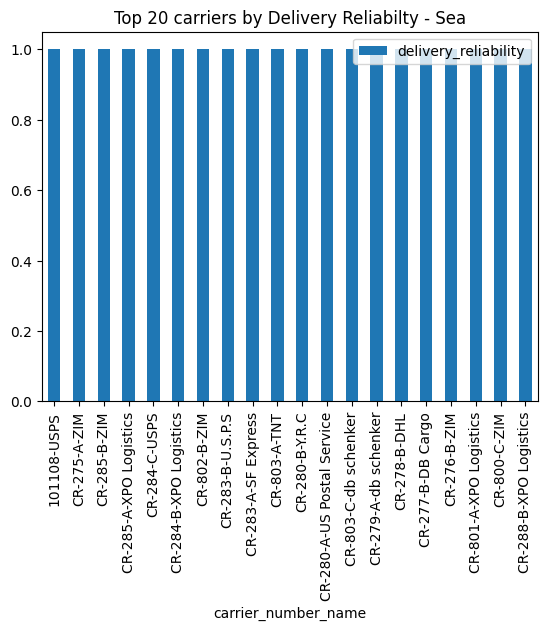

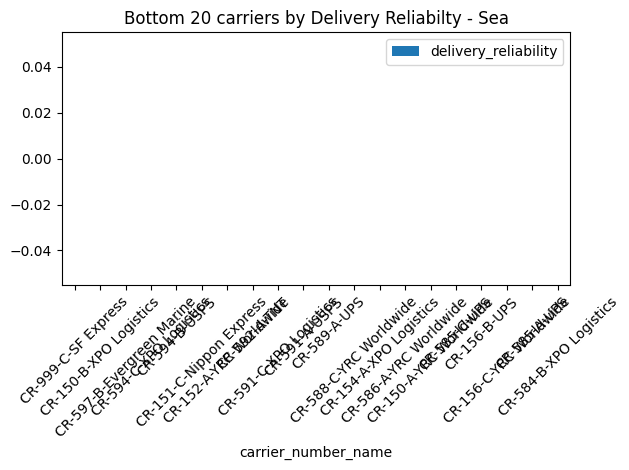

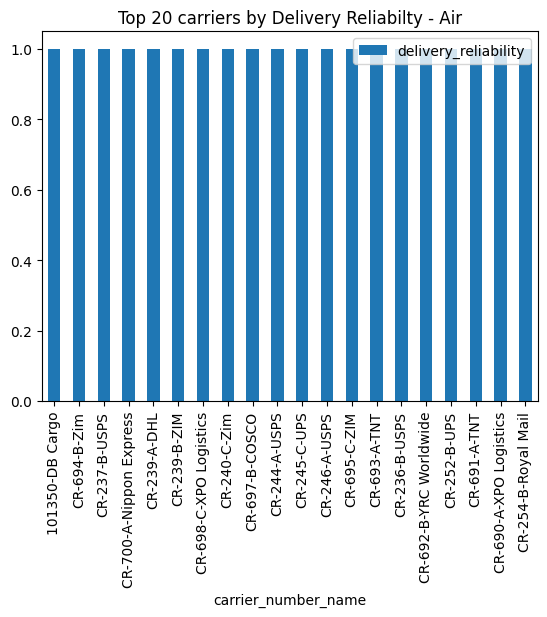

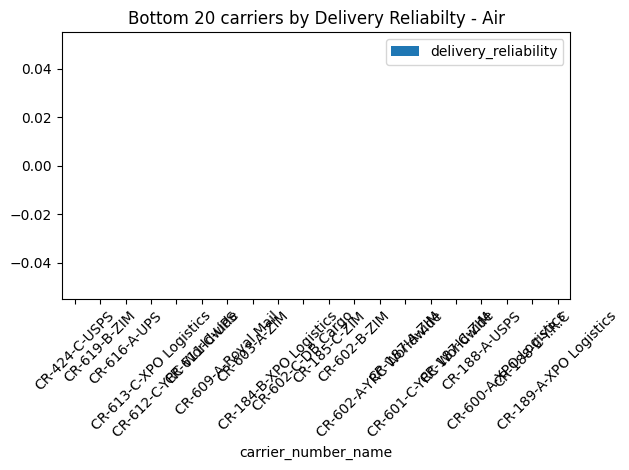

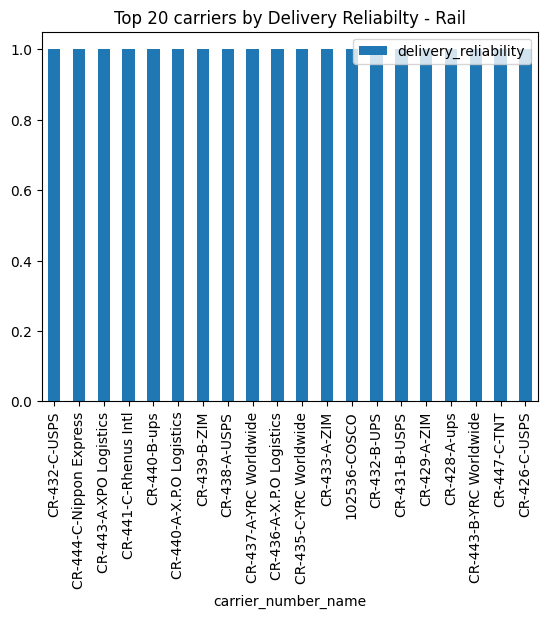

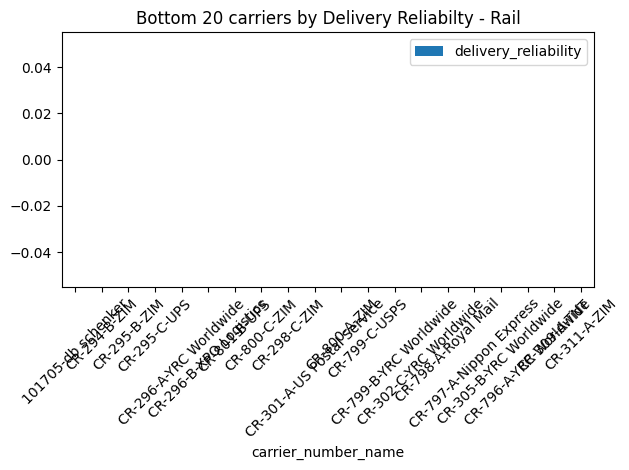

In [709]:
top_average_delivery_reliability = {}
bottom_average_delivery_reliability = {}


for mode in list(clean_df['transport_mode'].unique()):
    top_average_delivery_reliability[mode] = clean_df[clean_df['transport_mode'] == mode].groupby("carrier_number_name").agg({'delivery_reliability':'mean'}).reset_index().sort_values(by="delivery_reliability", ascending=False)[:20]
    bottom_average_delivery_reliability[mode] = clean_df[clean_df['transport_mode'] == mode].groupby("carrier_number_name").agg({'delivery_reliability':'mean'}).reset_index().sort_values(by="delivery_reliability", ascending=True)[:20]
    top_average_delivery_reliability[mode].plot(kind='bar',  x='carrier_number_name')
    plt.title(f'Top 20 carriers by Delivery Reliabilty - {mode}')
    bottom_average_delivery_reliability[mode].plot(kind='bar', x='carrier_number_name')
    plt.title(f'Bottom 20 carriers by Delivery Reliabilty - {mode}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
   

Non Conformance

Text(0, 0.5, 'Counts')

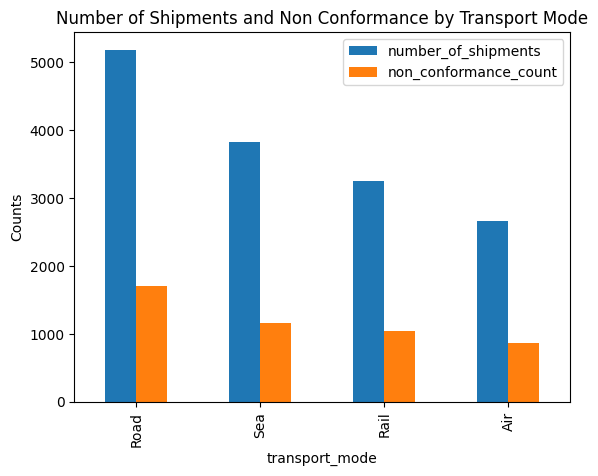

In [710]:
non_conformance = clean_df.groupby('transport_mode').agg({'shipment_number':'nunique', 'non_conformance_count':'sum'}).reset_index().sort_values(by='shipment_number', ascending=False)
non_conformance = non_conformance.rename(columns={'shipment_number':'number_of_shipments'})
non_conformance.plot(kind='bar', x='transport_mode')
plt.title('Number of Shipments and Non Conformance by Transport Mode')
plt.ylabel("Counts")

<Axes: xlabel='transport_mode'>

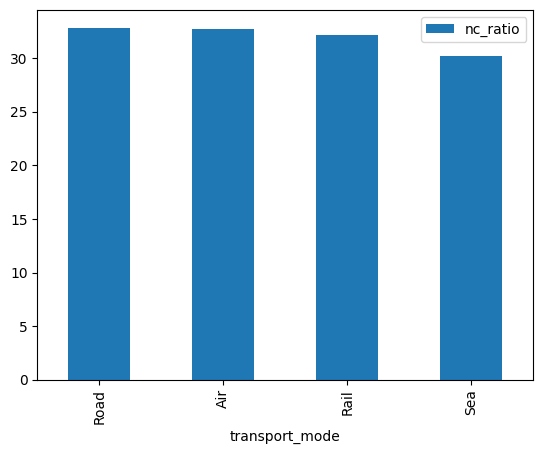

In [711]:
non_conformance['nc_ratio'] = non_conformance['non_conformance_count']/non_conformance['number_of_shipments'] * 100

non_conformance.sort_values(by='nc_ratio', ascending=False).plot(kind="bar", x="transport_mode", y='nc_ratio')

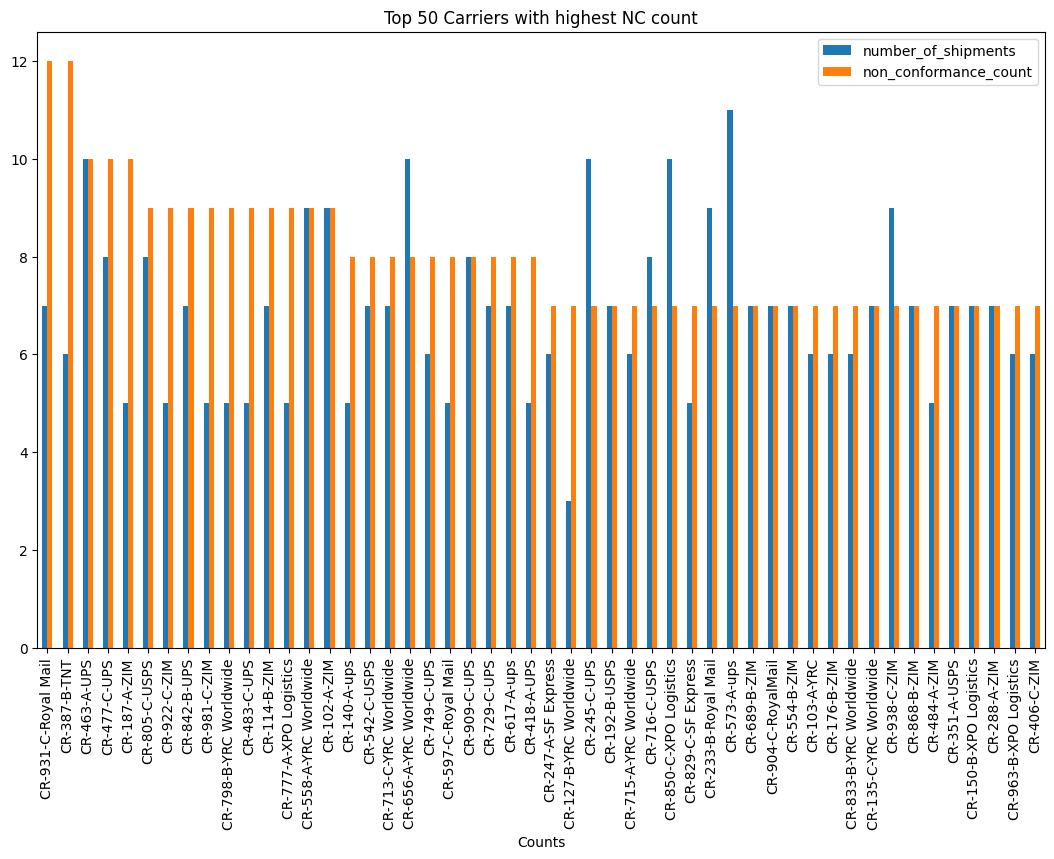

In [712]:
non_conformance_carrier = clean_df.groupby('carrier_number_name').agg({'shipment_number':'nunique', 'non_conformance_count':'sum'}).reset_index().sort_values(by='non_conformance_count', ascending=False).head(50)
non_conformance_carrier = non_conformance_carrier.rename(columns={'shipment_number':'number_of_shipments'})
non_conformance_carrier.plot(kind='bar', x='carrier_number_name', figsize=(13,8))
plt.title('Top 50 Carriers with highest NC count')
plt.xlabel("Counts")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

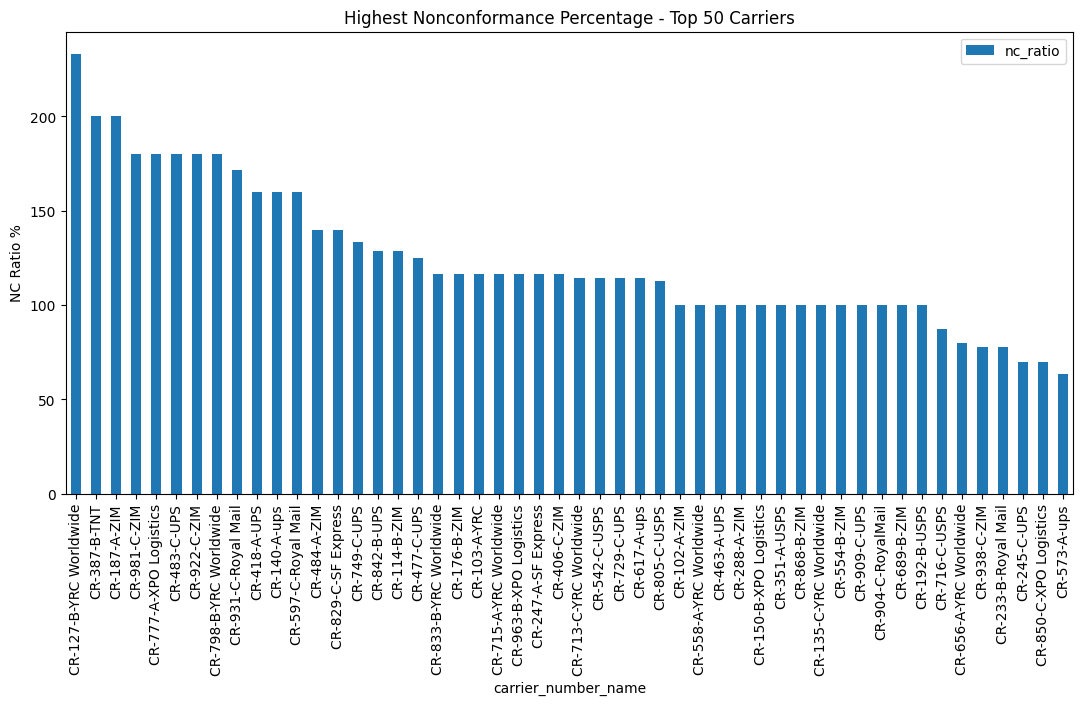

In [713]:
non_conformance_carrier['nc_ratio'] = non_conformance_carrier['non_conformance_count']/non_conformance_carrier['number_of_shipments'] * 100

non_conformance_carrier.sort_values(by='nc_ratio', ascending=False).head(50).plot(kind="bar", x="carrier_number_name", y='nc_ratio', figsize=(13,6))
plt.ylabel('NC Ratio %')
plt.title("Highest Nonconformance Percentage - Top 50 Carriers")
plt.show

plotting Pairplots and Heat Maps

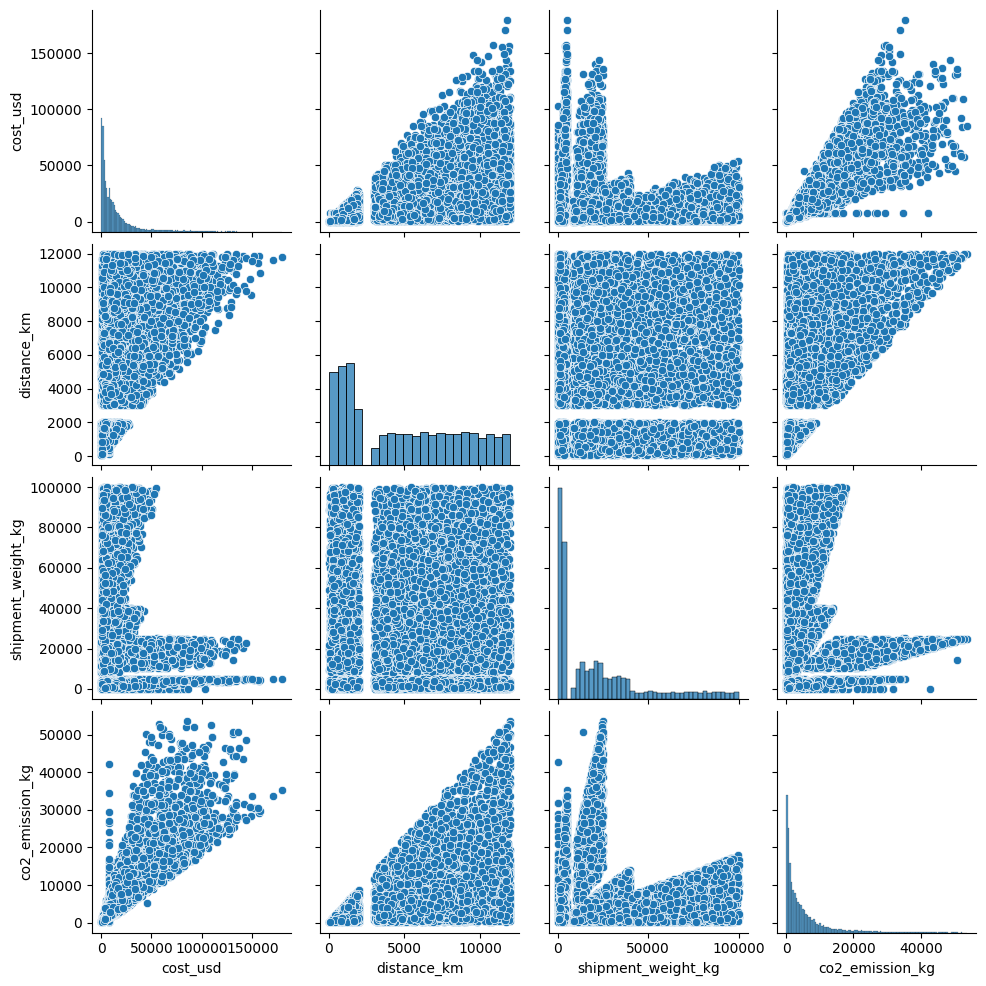

In [714]:
sns.pairplot(clean_df[["cost_usd", "distance_km", "shipment_weight_kg", "co2_emission_kg"]])
plt.show()

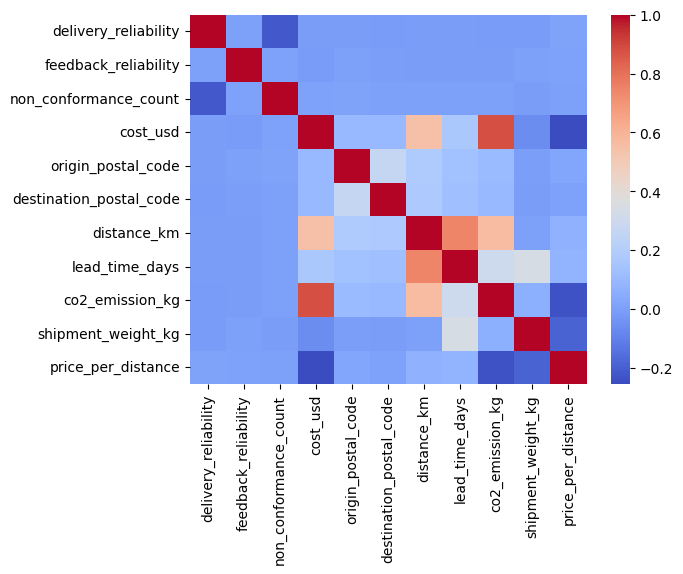

In [715]:
sns.heatmap(clean_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.show()


In [716]:
clean_df.head()

carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count transport_mode  \
0       CR-904-C       SHP904437    2023-06-04    2023-06-10                     1                     1                      0           Road   
1       CR-533-B       SHP499266    2024-04-07    2024-04-18                     1                     0                      0            Sea   
2       CR-970-A       SHP227384    2023-09-13    2023-09-16                     1                     0                      0            Air   
3         977970       SHP516508    2025-02-15    2025-02-26                     0                     0                      0           Road   
4       CR-601-A       SHP976649    2023-06-15    2023-06-19                     1                     1                      0           Road   

   cost_usd         region  ... destination_country  destination_postal_code distance_km  lead_time_days  co2_emission_kg  shipment_weight_kg  \
0   7965.47  Latin America  ...                  BR                    76521     5995.28               6          3556.43             3295.59   
1  20696.89         Africa  ...                  NG                   577543     7614.42              11         10062.87            88103.65   
2   4455.99           Asia  ...                  JP                   742986     1439.82               3          1295.29             1499.37   
3  30704.21         Europe  ...                  ZA                   850479    11789.43              11          6589.36             3105.12   
4  33841.75  North America  ...                  EG                   771949     5154.71               4         22588.48            24345.03   

   first_carrier_name   carrier_number_name year_month price_per_distance  
0           RoyalMail    CR-904-C-RoyalMail    2023-06               0.75  
1          Royal Mail   CR-533-B-Royal Mail    2024-04               0.37  
2                USPS         CR-970-A-USPS    2023-09               0.32  
3       XPO Logistics  977970-XPO Logistics    2025-02               0.38  
4                USPS         CR-601-A-USPS    2023-06               0.15  

[5 rows x 22 columns]

In [717]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14923 entries, 0 to 14922
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   carrier_number           14923 non-null  object        
 1   shipment_number          14923 non-null  object        
 2   shipment_date            14923 non-null  object        
 3   delivery_date            14923 non-null  datetime64[ns]
 4   delivery_reliability     14923 non-null  int64         
 5   feedback_reliability     14923 non-null  int64         
 6   non_conformance_count    14923 non-null  int64         
 7   transport_mode           14923 non-null  object        
 8   cost_usd                 14923 non-null  float64       
 9   region                   14923 non-null  object        
 10  origin_country           14923 non-null  object        
 11  origin_postal_code       14923 non-null  int64         
 12  destination_country      14923 n

What are the number of Shipments By Lane?

In [718]:
def first_two(value):
    value = str(value)
    new_value = value[:2]
    return new_value

In [719]:
clean_df['origin_postal_code_2_digit'] = clean_df['origin_postal_code'].apply(first_two)

In [720]:
clean_df['destination_postal_code_2_digit'] = clean_df['destination_postal_code'].apply(first_two)

In [721]:
clean_df[["origin_postal_code", "destination_postal_code", "origin_postal_code_2_digit","destination_postal_code_2_digit" ]].head()

origin_postal_code  destination_postal_code origin_postal_code_2_digit destination_postal_code_2_digit
0              307576                    76521                         30                              76
1              494082                   577543                         49                              57
2              827682                   742986                         82                              74
3                5023                   850479                         50                              85
4               98054                   771949                         98                              77

In [722]:
clean_df['lane'] = clean_df['origin_country'] + clean_df['origin_postal_code_2_digit'] + '-->' + clean_df['destination_country'] + clean_df['destination_postal_code_2_digit']

In [723]:
clean_df.head()

carrier_number shipment_number shipment_date delivery_date  delivery_reliability  feedback_reliability  non_conformance_count transport_mode  \
0       CR-904-C       SHP904437    2023-06-04    2023-06-10                     1                     1                      0           Road   
1       CR-533-B       SHP499266    2024-04-07    2024-04-18                     1                     0                      0            Sea   
2       CR-970-A       SHP227384    2023-09-13    2023-09-16                     1                     0                      0            Air   
3         977970       SHP516508    2025-02-15    2025-02-26                     0                     0                      0           Road   
4       CR-601-A       SHP976649    2023-06-15    2023-06-19                     1                     1                      0           Road   

   cost_usd         region  ... lead_time_days  co2_emission_kg shipment_weight_kg  first_carrier_name   carrier_number_name  year_month  \
0   7965.47  Latin America  ...              6          3556.43            3295.59           RoyalMail    CR-904-C-RoyalMail     2023-06   
1  20696.89         Africa  ...             11         10062.87           88103.65          Royal Mail   CR-533-B-Royal Mail     2024-04   
2   4455.99           Asia  ...              3          1295.29            1499.37                USPS         CR-970-A-USPS     2023-09   
3  30704.21         Europe  ...             11          6589.36            3105.12       XPO Logistics  977970-XPO Logistics     2025-02   
4  33841.75  North America  ...              4         22588.48           24345.03                USPS         CR-601-A-USPS     2023-06   

   price_per_distance  origin_postal_code_2_digit destination_postal_code_2_digit         lane  
0                0.75                          30                              76  CO30-->BR76  
1                0.37                          49                              57  ZA49-->NG57  
2                0.32                          82                              74  IN82-->JP74  
3                0.38                          50                              85  SE50-->ZA85  
4                0.15                          98                              77  MX98-->EG77  

[5 rows x 25 columns]

Text(0, 0.5, 'number of shipments')

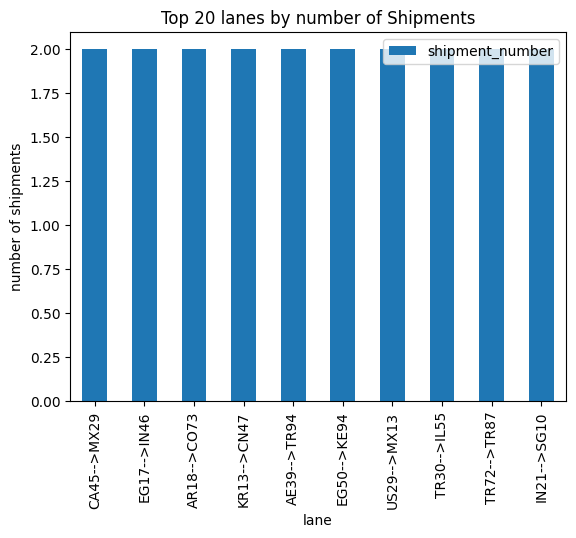

In [724]:

clean_df.groupby("lane").agg({'shipment_number':"nunique"}).sort_values(by='shipment_number',ascending=False)[:10].plot(kind='bar')
plt.title("Top 20 lanes by number of Shipments")
plt.ylabel('number of shipments')

Text(0, 0.5, 'number of shipments')

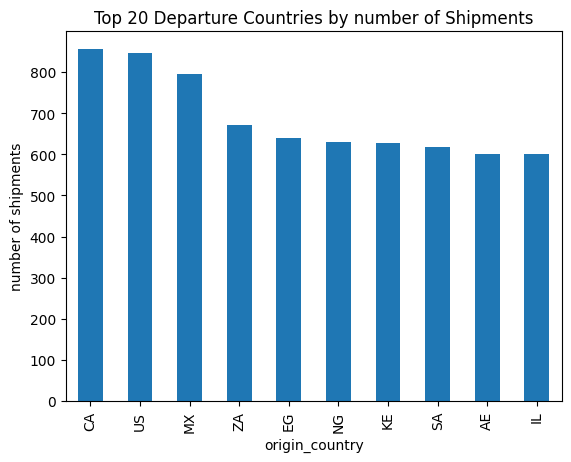

In [725]:
clean_df.origin_country.value_counts().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title("Top 20 Departure Countries by number of Shipments")
plt.ylabel('number of shipments')

Text(0, 0.5, 'number of shipments')

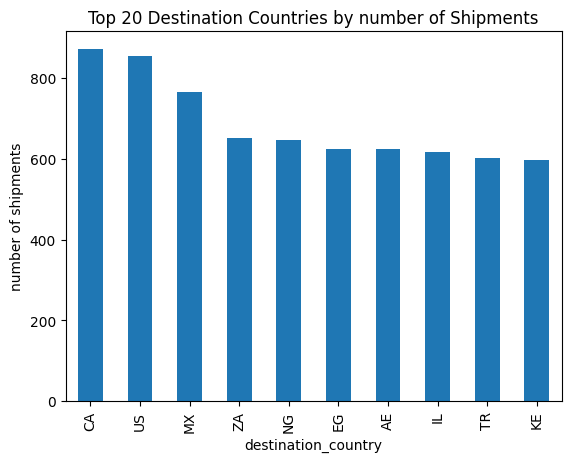

In [726]:
clean_df.destination_country.value_counts().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title("Top 20 Destination Countries by number of Shipments")
plt.ylabel('number of shipments')

In [727]:
clean_df['country_lane'] = clean_df['origin_country']  + '-->' + clean_df['destination_country'] 

Text(0, 0.5, 'number of shipments')

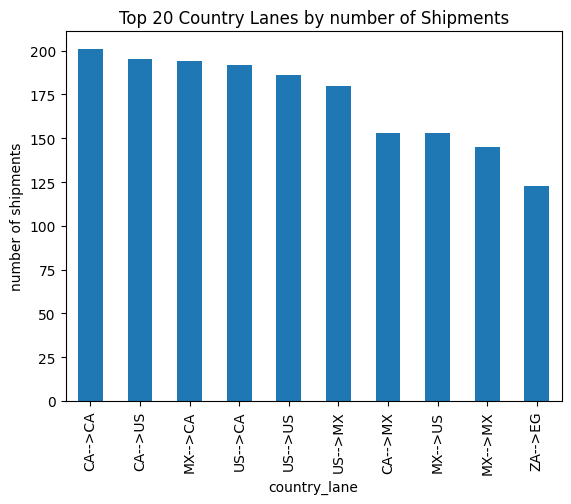

In [728]:
clean_df.groupby("country_lane").size().sort_values(ascending=False)[:10].plot(kind='bar')

plt.title("Top 20 Country Lanes by number of Shipments")
plt.ylabel('number of shipments')
plt.ylabel('number of shipments')


What's the total cost by lanes?

Text(0, 0.5, 'Total Cost USD')

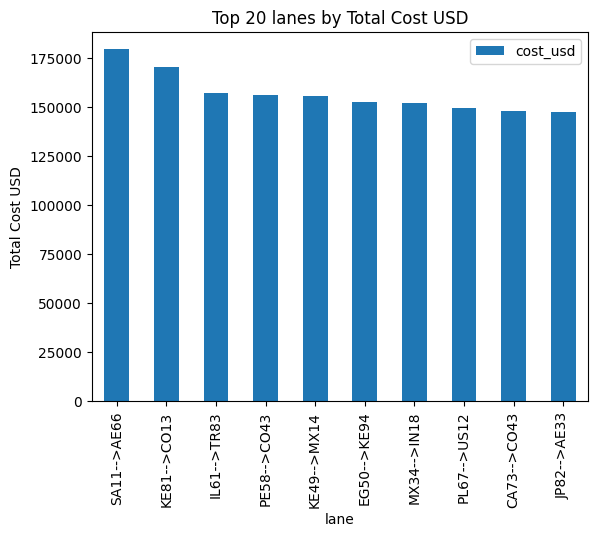

In [729]:
clean_df.groupby("lane").agg({"cost_usd":"sum"}).reset_index().sort_values(by="cost_usd",ascending=False)[:10].plot(kind='bar', x='lane')
plt.title("Top 20 lanes by Total Cost USD")
plt.ylabel('Total Cost USD')

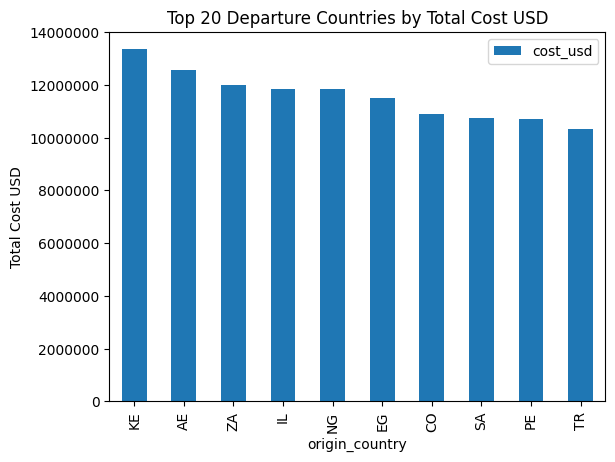

In [730]:
clean_df.groupby('origin_country').agg({"cost_usd":"sum"}).reset_index().sort_values(by='cost_usd',ascending=False)[:10].plot(kind='bar', x='origin_country')
plt.gca().ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Departure Countries by Total Cost USD")
plt.ylabel('Total Cost USD')
plt.show()

Text(0, 0.5, 'Total Cost USD')

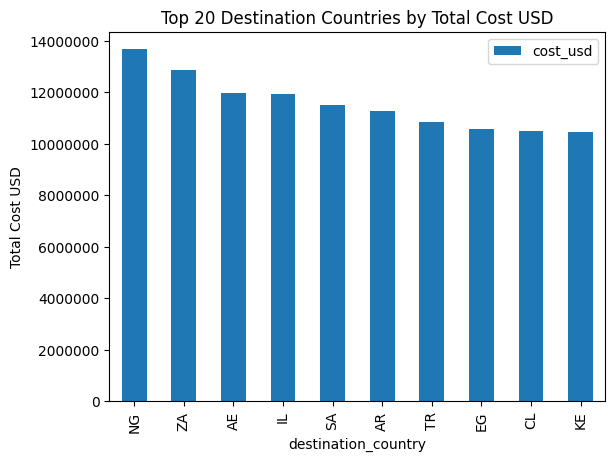

In [731]:
clean_df.groupby('destination_country').agg({"cost_usd":"sum"}).reset_index().sort_values(by='cost_usd',ascending=False)[:10].plot(kind='bar', x='destination_country')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Destination Countries by Total Cost USD")
plt.ylabel('Total Cost USD')

Text(0, 0.5, 'Total Cost USD')

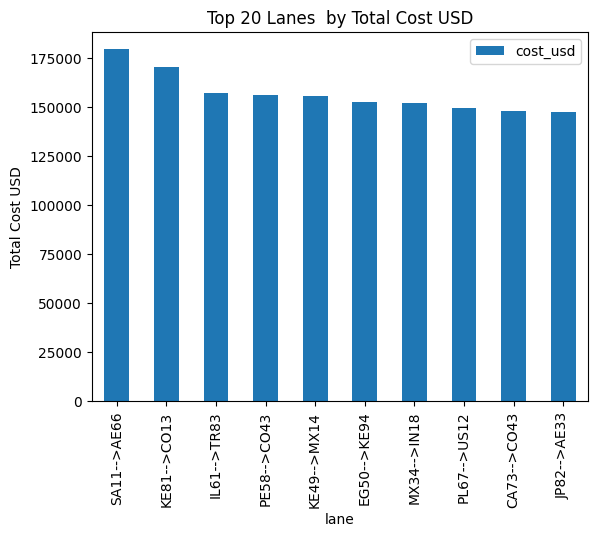

In [732]:
clean_df.groupby('lane').agg({"cost_usd":"sum"}).reset_index().sort_values(by='cost_usd',ascending=False)[:10].plot(kind='bar', x='lane')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.title("Top 20 Lanes  by Total Cost USD")
plt.ylabel('Total Cost USD')

In [733]:
clean_df.to_csv("clean_data.csv", index=False)